In [1]:
import pandas as pd
pd.set_option("display.max_columns",500)
pd.set_option("display.max_rows",1000)
import os
import logging
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from scipy import stats
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
logger = logging.getLogger('crab_analysis')
logger.setLevel(logging.DEBUG)
logger.handlers = []
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)


In [3]:
raw_df = pd.read_csv("crab_data.csv")

In [4]:
raw_df.head()

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [5]:
raw_df.dtypes

sex                object
length            float64
diameter          float64
height            float64
weight            float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
age                 int64
dtype: object

In [6]:
datatypes = raw_df.dtypes

In [7]:
raw_df.describe(include="all")

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
count,3894,3894.000000,3894.000000,3894.000000,3893.000000,3894.000000,3893.000000,3893.000000,3894.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.311415,1.020984,0.349403,23.567275,10.210581,5.136546,6.795844,9.954802
std,NaN,0.300470,0.248266,0.104978,13.891201,6.277724,3.104133,3.943392,3.220553
min,NaN,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,NaN,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,NaN,1.362500,1.062500,0.362500,22.792998,9.546694,4.861939,6.662132,10.000000
75%,NaN,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000


In [8]:
logger.debug("Number of null rows for sex {0}".format(len(raw_df[raw_df["sex"].isnull()])))
logger.debug("Number of null rows for length {0}".format(len(raw_df[raw_df["length"].isnull()])))
logger.debug("Number of null rows for diameter {0}".format(len(raw_df[raw_df["diameter"].isnull()])))
logger.debug("Number of null rows for height {0}".format(len(raw_df[raw_df["height"].isnull()])))
logger.debug("Number of null rows for weight {0}".format(len(raw_df[raw_df["weight"].isnull()])))
logger.debug("Number of null rows for shucked_weight {0}".format(len(raw_df[raw_df["shucked_weight"].isnull()])))
logger.debug("Number of null rows for viscera_weight {0}".format(len(raw_df[raw_df["viscera_weight"].isnull()])))
logger.debug("Number of null rows for shell_weight {0}".format(len(raw_df[raw_df["shell_weight"].isnull()])))
logger.debug("Number of null rows for age {0}".format(len(raw_df[raw_df["age"].isnull()])))

2019-12-04 23:14:36,453 - crab_analysis - DEBUG - Number of null rows for sex 0
2019-12-04 23:14:36,455 - crab_analysis - DEBUG - Number of null rows for length 0
2019-12-04 23:14:36,457 - crab_analysis - DEBUG - Number of null rows for diameter 0
2019-12-04 23:14:36,459 - crab_analysis - DEBUG - Number of null rows for height 0
2019-12-04 23:14:36,461 - crab_analysis - DEBUG - Number of null rows for weight 1
2019-12-04 23:14:36,462 - crab_analysis - DEBUG - Number of null rows for shucked_weight 0
2019-12-04 23:14:36,463 - crab_analysis - DEBUG - Number of null rows for viscera_weight 1
2019-12-04 23:14:36,465 - crab_analysis - DEBUG - Number of null rows for shell_weight 1
2019-12-04 23:14:36,466 - crab_analysis - DEBUG - Number of null rows for age 0


In [9]:
# since weight is further broken down into shucked weight, shell weight and viscera weight, instead of taking mean, i could have
# divided it into those, but the weight column was missing as well
logger.debug("Number of NaN rows for sex {0}".format(len(raw_df[raw_df["sex"].isna()])))
logger.debug("Number of NaN rows for length {0}".format(len(raw_df[raw_df["length"].isna()])))
logger.debug("Number of NaN rows for diameter {0}".format(len(raw_df[raw_df["diameter"].isna()])))
logger.debug("Number of NaN rows for height {0}".format(len(raw_df[raw_df["height"].isna()])))
logger.debug("Number of NaN rows for weight {0}".format(len(raw_df[raw_df["weight"].isna()])))
logger.debug("Number of NaN rows for shucked_weight {0}".format(len(raw_df[raw_df["shucked_weight"].isna()])))
logger.debug("Number of NaN rows for viscera_weight {0}".format(len(raw_df[raw_df["viscera_weight"].isna()])))
logger.debug("Number of NaN rows for shell_weight {0}".format(len(raw_df[raw_df["shell_weight"].isna()])))
logger.debug("Number of NaN rows for age {0}".format(len(raw_df[raw_df["age"].isna()])))

2019-12-04 23:14:36,575 - crab_analysis - DEBUG - Number of NaN rows for sex 0
2019-12-04 23:14:36,579 - crab_analysis - DEBUG - Number of NaN rows for length 0
2019-12-04 23:14:36,582 - crab_analysis - DEBUG - Number of NaN rows for diameter 0
2019-12-04 23:14:36,589 - crab_analysis - DEBUG - Number of NaN rows for height 0
2019-12-04 23:14:36,593 - crab_analysis - DEBUG - Number of NaN rows for weight 1
2019-12-04 23:14:36,595 - crab_analysis - DEBUG - Number of NaN rows for shucked_weight 0
2019-12-04 23:14:36,597 - crab_analysis - DEBUG - Number of NaN rows for viscera_weight 1
2019-12-04 23:14:36,599 - crab_analysis - DEBUG - Number of NaN rows for shell_weight 1
2019-12-04 23:14:36,601 - crab_analysis - DEBUG - Number of NaN rows for age 0


In [10]:
raw_df.fillna(raw_df.mean(), inplace=True)
columns = ["length","diameter","height","weight","shucked_weight","viscera_weight","shell_weight","age","sex"]
continuous_var_columns = ["length","diameter","height","weight","shucked_weight","viscera_weight","shell_weight","age"]

In [11]:
# Processing sex variable
logger.debug("Number of Male crabs: {0}".format(len(raw_df[raw_df.sex == "M"])))
logger.debug("Number of Female crabs: {0}".format(len(raw_df[raw_df.sex == "F"])))
logger.debug("Number of indeterminate crabs: {0}".format(len(raw_df[raw_df.sex == "I"])))

2019-12-04 23:14:36,758 - crab_analysis - DEBUG - Number of Male crabs: 1435
2019-12-04 23:14:36,763 - crab_analysis - DEBUG - Number of Female crabs: 1226
2019-12-04 23:14:36,773 - crab_analysis - DEBUG - Number of indeterminate crabs: 1233


In [12]:
correlation_matrix = raw_df.drop(["sex"], axis=1).corr()

In [13]:
correlation_matrix

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
length,1.000000,0.986660,0.823138,0.925134,0.898215,0.903019,0.897504,0.554835
diameter,0.986660,1.000000,0.829586,0.925528,0.893665,0.899575,0.905325,0.573700
height,0.823138,0.829586,1.000000,0.814284,0.771003,0.793153,0.812169,0.551878
weight,0.925134,0.925528,0.814284,1.000000,0.968575,0.965583,0.955269,0.538819
shucked_weight,0.898215,0.893665,0.771003,0.968575,1.000000,0.930797,0.881949,0.418550
viscera_weight,0.903019,0.899575,0.793153,0.965583,0.930797,1.000000,0.906105,0.501328
shell_weight,0.897504,0.905325,0.812169,0.955269,0.881949,0.906105,1.000000,0.625195
age,0.554835,0.573700,0.551878,0.538819,0.418550,0.501328,0.625195,1.000000


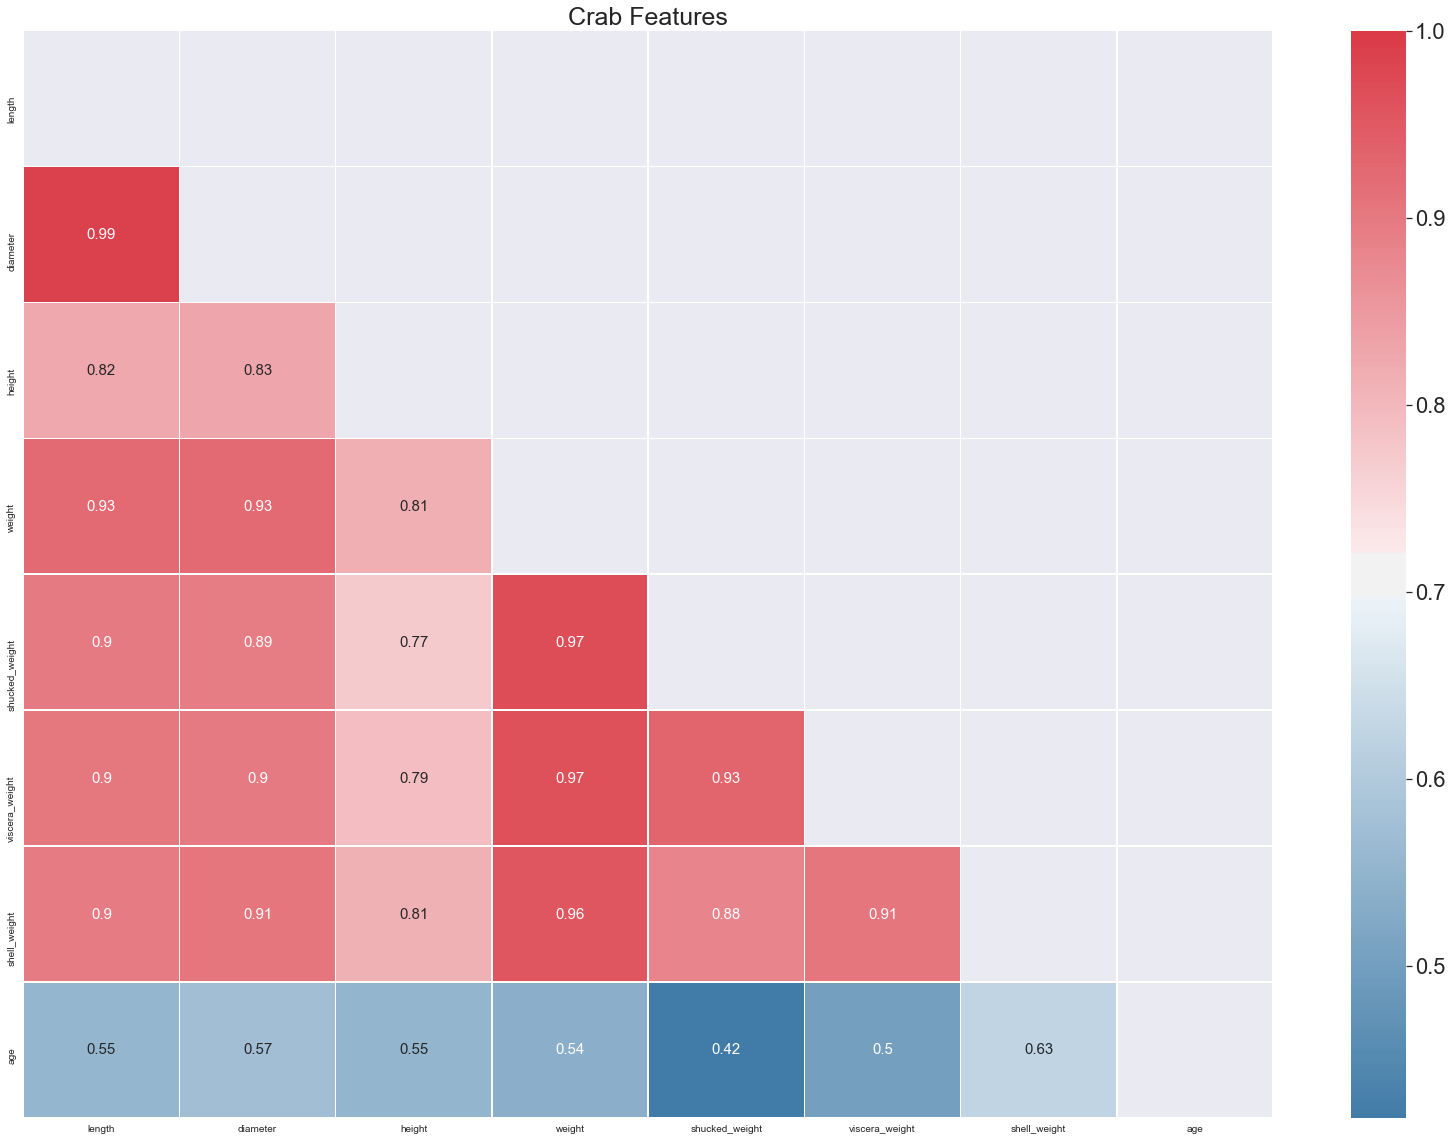

In [14]:
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(28, 20))
cmap = sns.dark_palette("#ff5959", reverse=True, input="rgb", as_cmap=True)
cmap2 = sns.cubehelix_palette(n_colors=15,start=2, as_cmap=True, dark=0.1)
cmap3 = sns.diverging_palette(240,10, n=20, as_cmap=True)
ax.set_title("Crab Features", fontsize=25)
sns.set(font_scale=2)
sns.heatmap(correlation_matrix, mask=mask,  linewidths=.5, cmap=cmap3,annot=True, annot_kws={"size": 15})
# plt.savefig("correlation_heatmap.jpg")

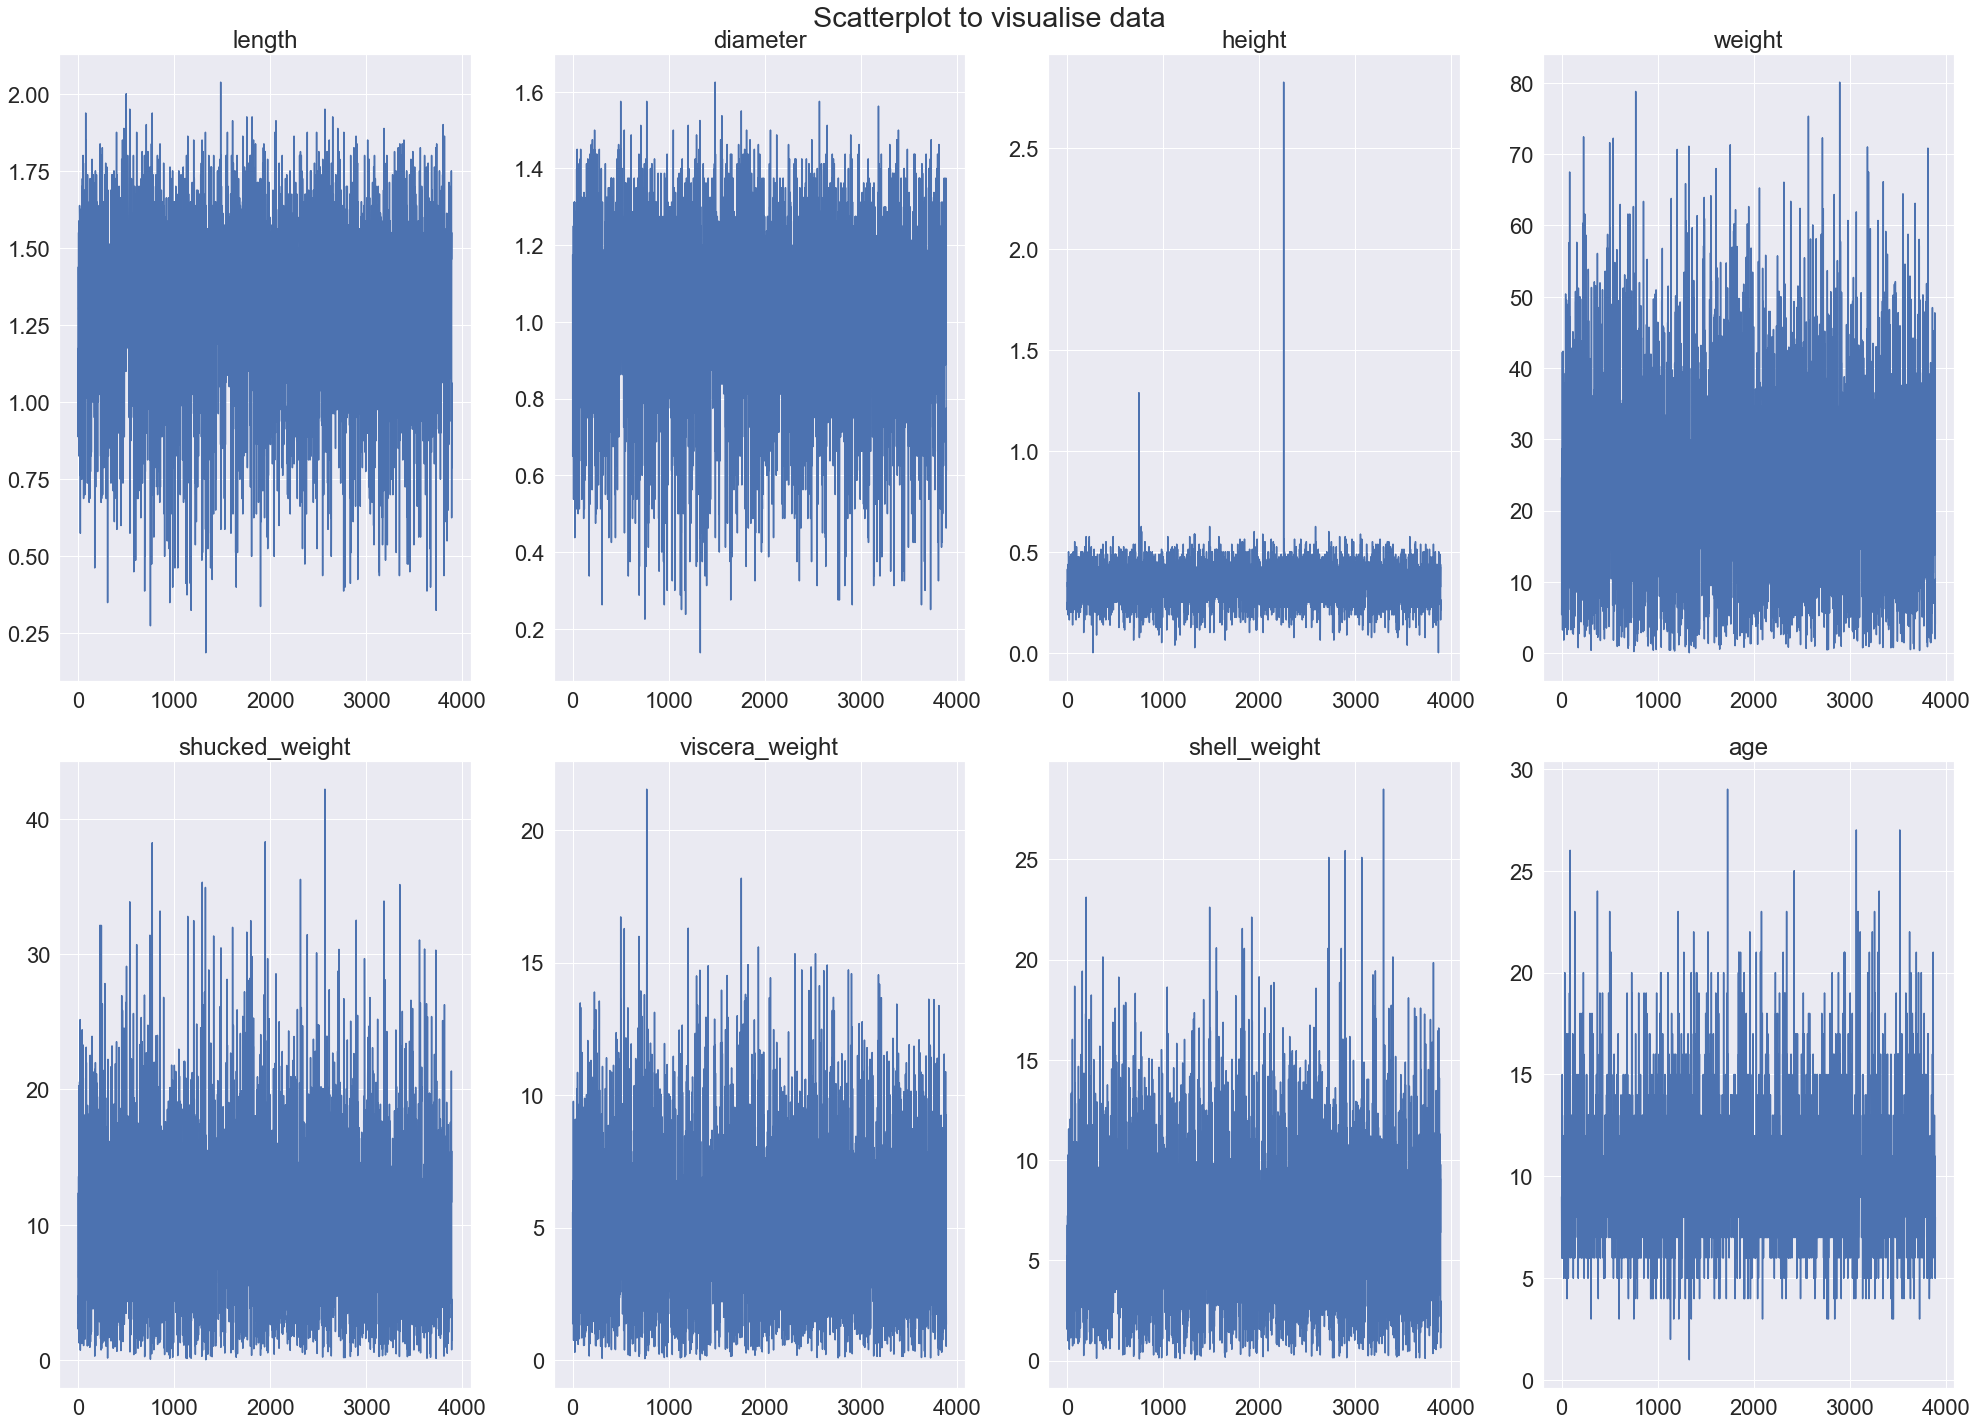

In [15]:
fig, axs = plt.subplots(2, 4,figsize=(28, 20))
axs[0, 0].plot(raw_df["length"])
axs[0, 0].set_title('length')
axs[0, 1].plot(raw_df["diameter"])
axs[0, 1].set_title('diameter')
axs[0, 2].plot(raw_df["height"])
axs[0, 2].set_title('height')
axs[0, 3].plot(raw_df["weight"])
axs[0, 3].set_title('weight')
axs[1, 0].plot(raw_df["shucked_weight"])
axs[1, 0].set_title('shucked_weight')
axs[1, 1].plot(raw_df["viscera_weight"])
axs[1, 1].set_title('viscera_weight')
axs[1, 2].plot(raw_df["shell_weight"])
axs[1, 2].set_title('shell_weight')
axs[1, 3].plot(raw_df["age"])
axs[1, 3].set_title('age')
fig.tight_layout()
plt.suptitle("Scatterplot to visualise data", verticalalignment='bottom')
plt.show()
# plt.savefig("scatter.jpg")

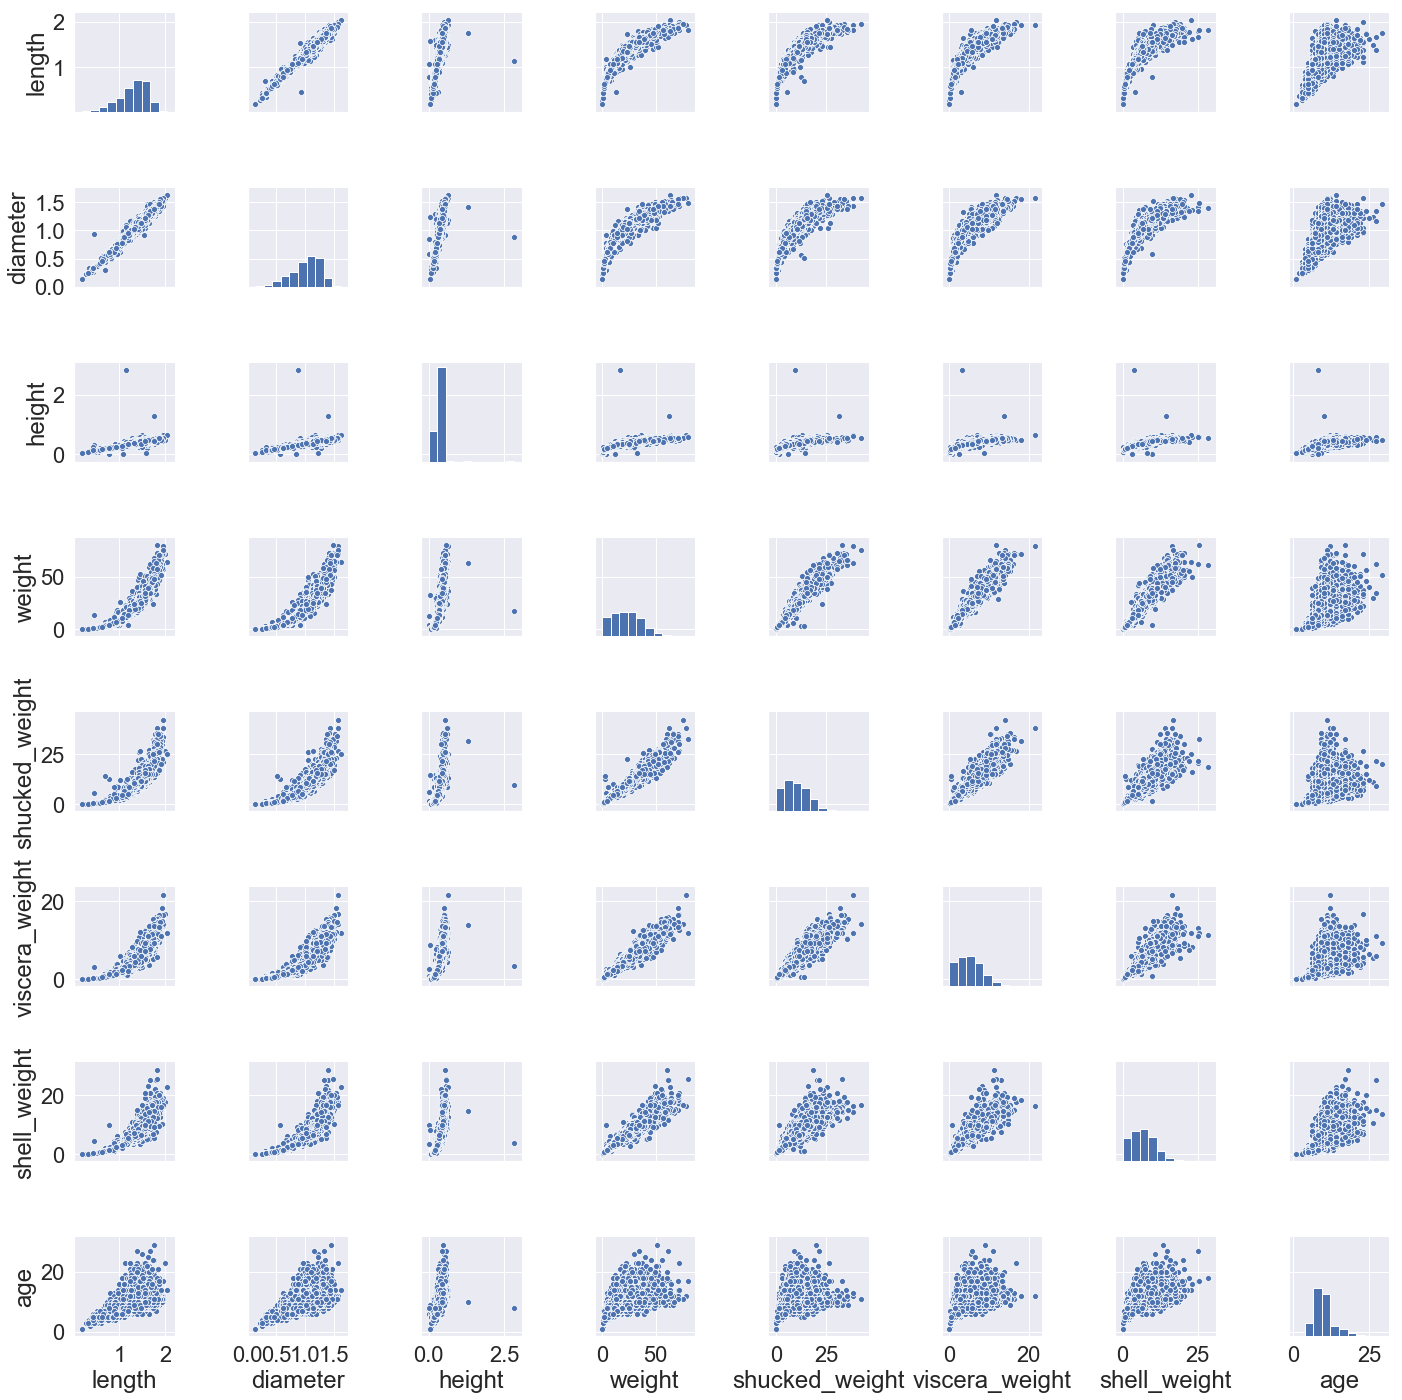

In [16]:
# Before making any decisions about removing outliers, I will eyeball the data
# This visualisation helps me to see the underlying distribution of data,  correlations between variables and skewness
# The length, diameter, and height variables follow a similar trend and are highly correlated with each other. 
# Length and height are also right skewed whereas most other continuous variables are left skewed. It seems there
# is non-linear relationship between data and the target variable.
g = sns.pairplot(raw_df,diag_kind="hist")
# g.savefig("pairplot.jpg")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


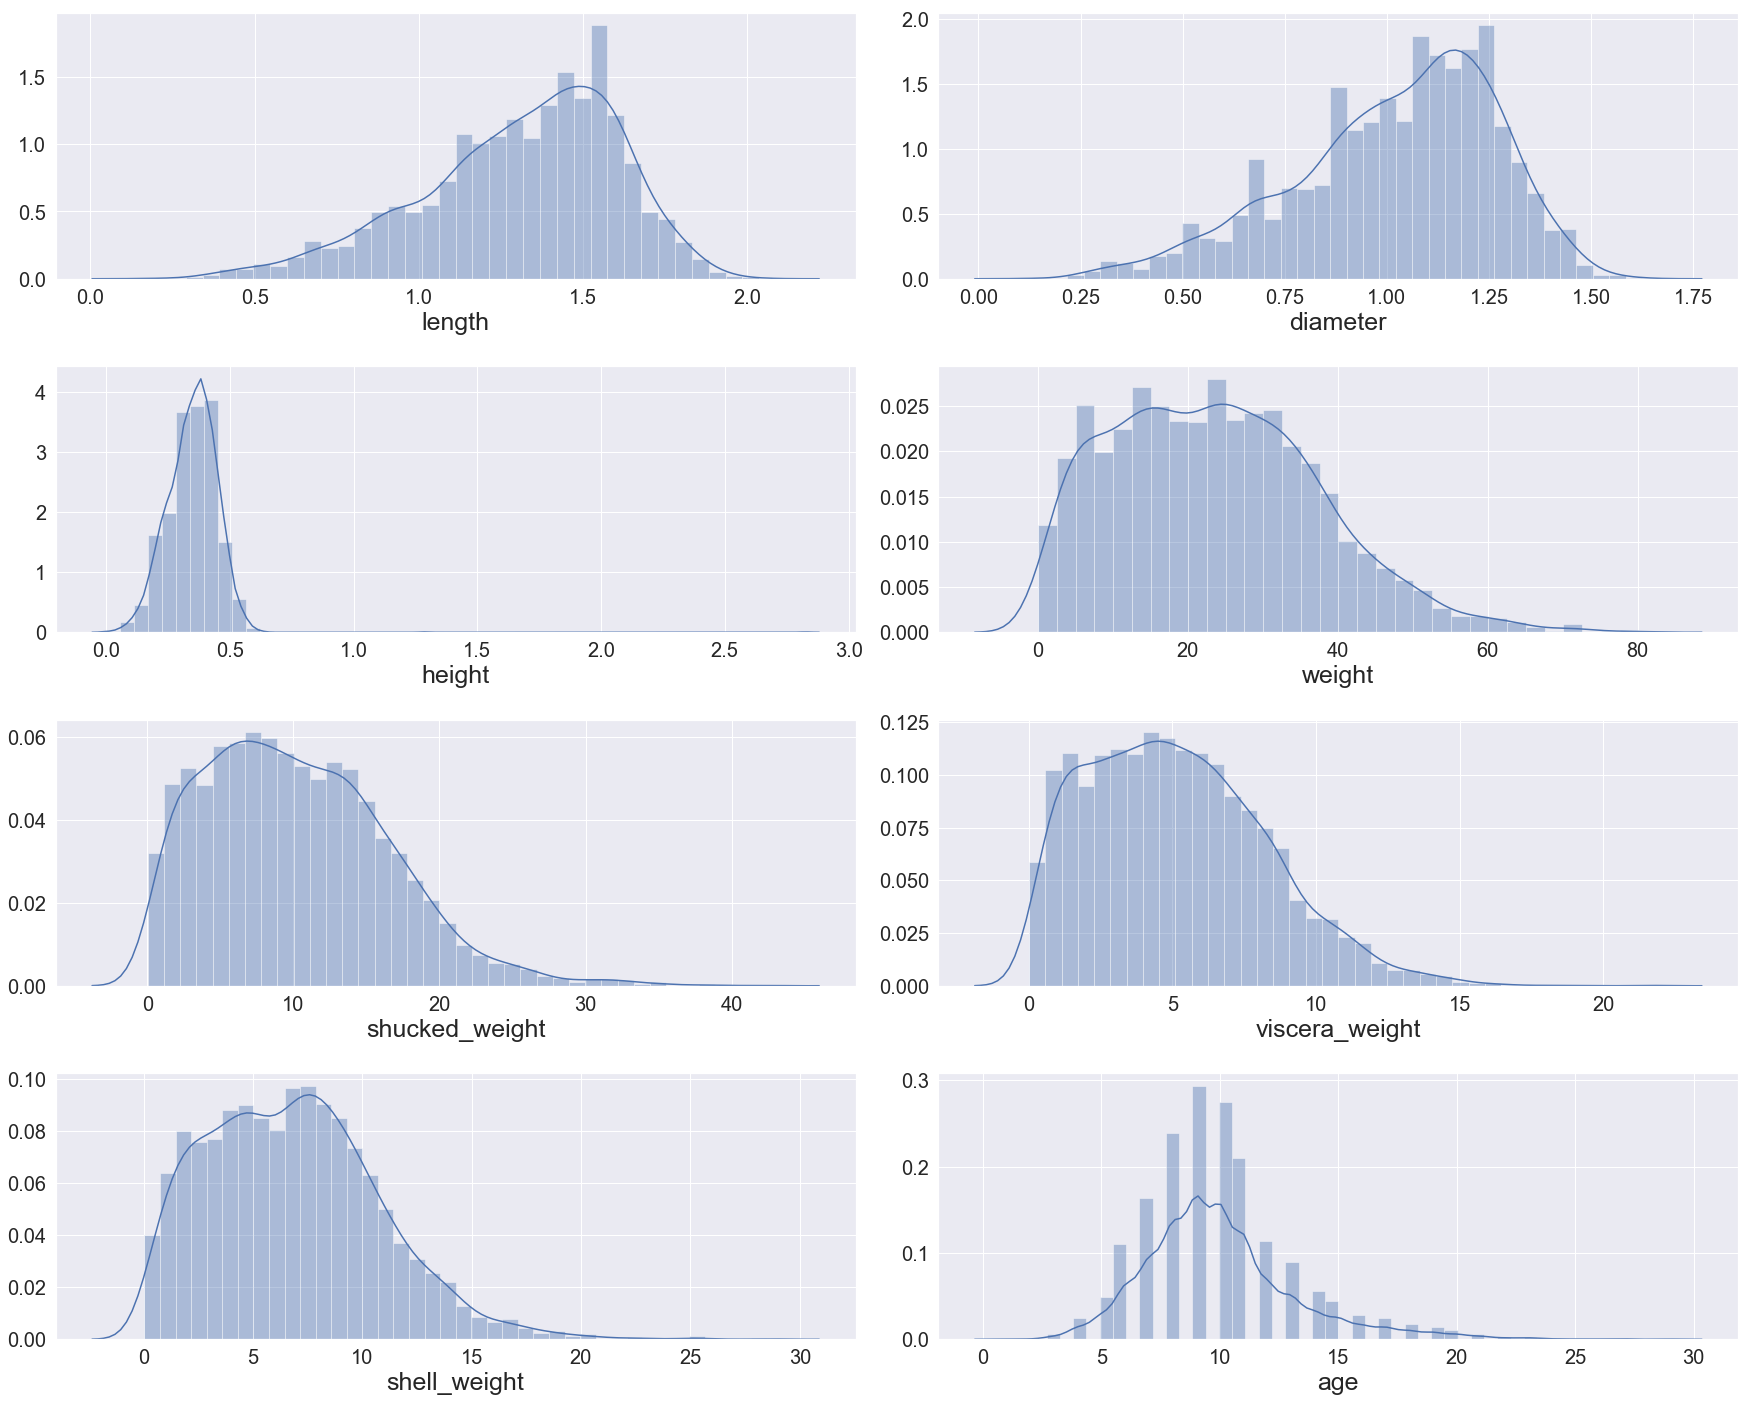

In [17]:
# This is another way of looking at data distribution. We can clearly see that data is right or left skewed and is not 
# mean-centred. Machine learning models, especially linear models tend to perform better when data is standardized and normalized

fig, axes = plt.subplots(4, 2, figsize=(25, 20), tight_layout=True)

sns.distplot(raw_df["length"], color="b",  ax=axes[0, 0])
axes[0,0].set_xlabel("length", fontsize=25)
axes[0,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["diameter"], color="b",  ax=axes[0, 1])
axes[0,1].set_xlabel("diameter", fontsize=25)
axes[0,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["height"], color="b",  ax=axes[1, 0])
axes[1,0].set_xlabel("height", fontsize=25)
axes[1,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["weight"], color="b",  ax=axes[1, 1])
axes[1,1].set_xlabel("weight", fontsize=25)
axes[1,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["shucked_weight"], color="b",  ax=axes[2, 0])
axes[2,0].set_xlabel("shucked_weight", fontsize=25)
axes[2,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["viscera_weight"], color="b",  ax=axes[2, 1])
axes[2,1].set_xlabel("viscera_weight", fontsize=25)
axes[2,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["shell_weight"], color="b",  ax=axes[3, 0])
axes[3,0].set_xlabel("shell_weight", fontsize=25)
axes[3,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(raw_df["age"], color="b",  ax=axes[3, 1])
axes[3,1].set_xlabel("age", fontsize=25)
axes[3,1].tick_params(axis='both', which='major', labelsize=20)
# plt.savefig("dist_plots.jpg")
plt.show()

In [18]:
logger.debug(raw_df["height"].mean())
logger.debug(raw_df["height"].std())

2019-12-04 23:14:50,068 - crab_analysis - DEBUG - 0.34940292758089364
2019-12-04 23:14:50,069 - crab_analysis - DEBUG - 0.10497840750990267


## Removing outliers

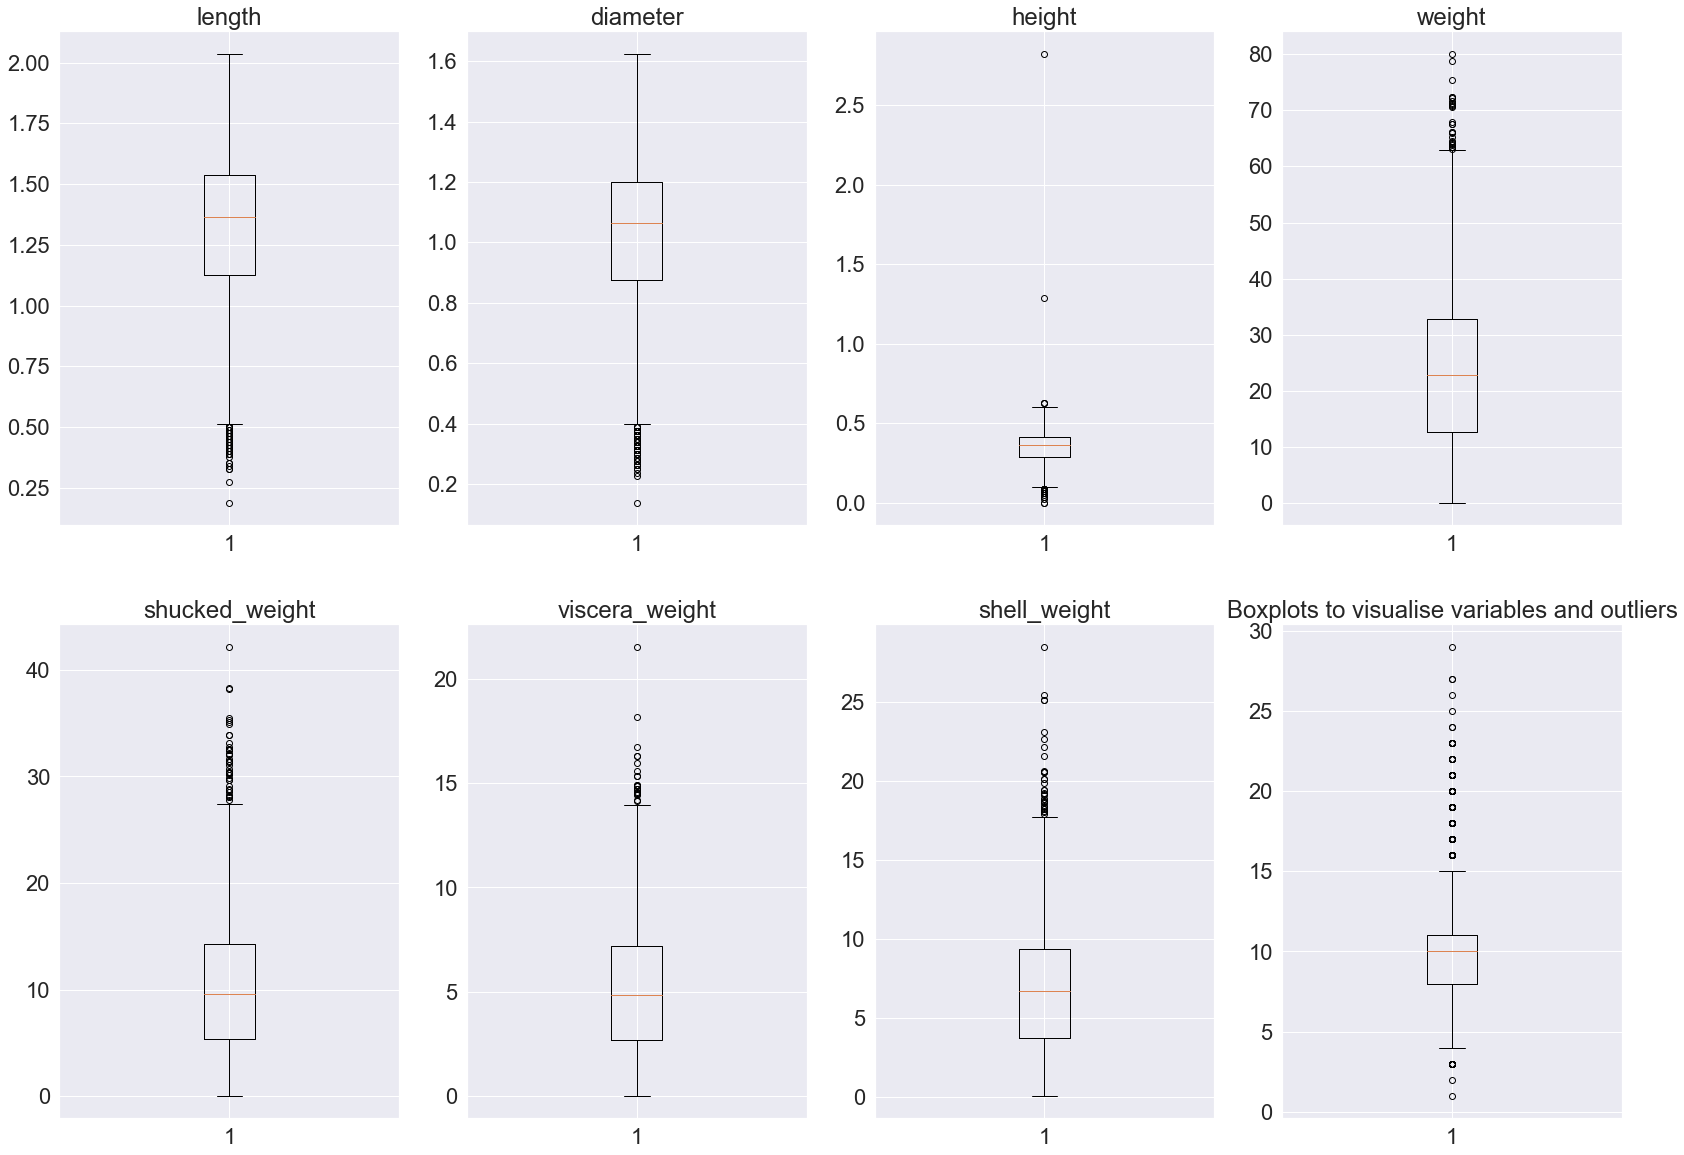

In [19]:
# Outliers detection for variables
columns = ["length","diameter","height","weight","shucked_weight","viscera_weight","shell_weight","age","sex"]

fig, axs = plt.subplots(2, 4,figsize=(28, 20))
axs[0, 0].boxplot(raw_df["length"])
axs[0, 0].set_title('length')
axs[0, 1].boxplot(raw_df["diameter"])
axs[0, 1].set_title('diameter')
axs[0, 2].boxplot(raw_df["height"])
axs[0, 2].set_title('height')
axs[0, 3].boxplot(raw_df["weight"])
axs[0, 3].set_title('weight')
axs[1, 0].boxplot(raw_df["shucked_weight"])
axs[1, 0].set_title('shucked_weight')
axs[1, 1].boxplot(raw_df["viscera_weight"])
axs[1, 1].set_title('viscera_weight')
axs[1, 2].boxplot(raw_df["shell_weight"])
axs[1, 2].set_title('shell_weight')
axs[1, 3].boxplot(raw_df["age"])
axs[1, 3].set_title('age')
plt.title("Boxplots to visualise variables and outliers")
plt.show()

# Boxplots are used for outlier detection. We can observe a number of data points which are away from the mean.

In [20]:
# Remove outliers 3 standard deviation away
raw_df_cont = raw_df[continuous_var_columns]
x = raw_df_cont[~(np.abs(stats.zscore(raw_df_cont)) < 3).all(axis=1)]

In [21]:
crab_df_woo = raw_df.drop(x.index)

In [22]:
logger.debug("Number of outlier rows deleted: {0}".format(len(x)))

2019-12-04 23:14:51,224 - crab_analysis - DEBUG - Number of outlier rows deleted: 138


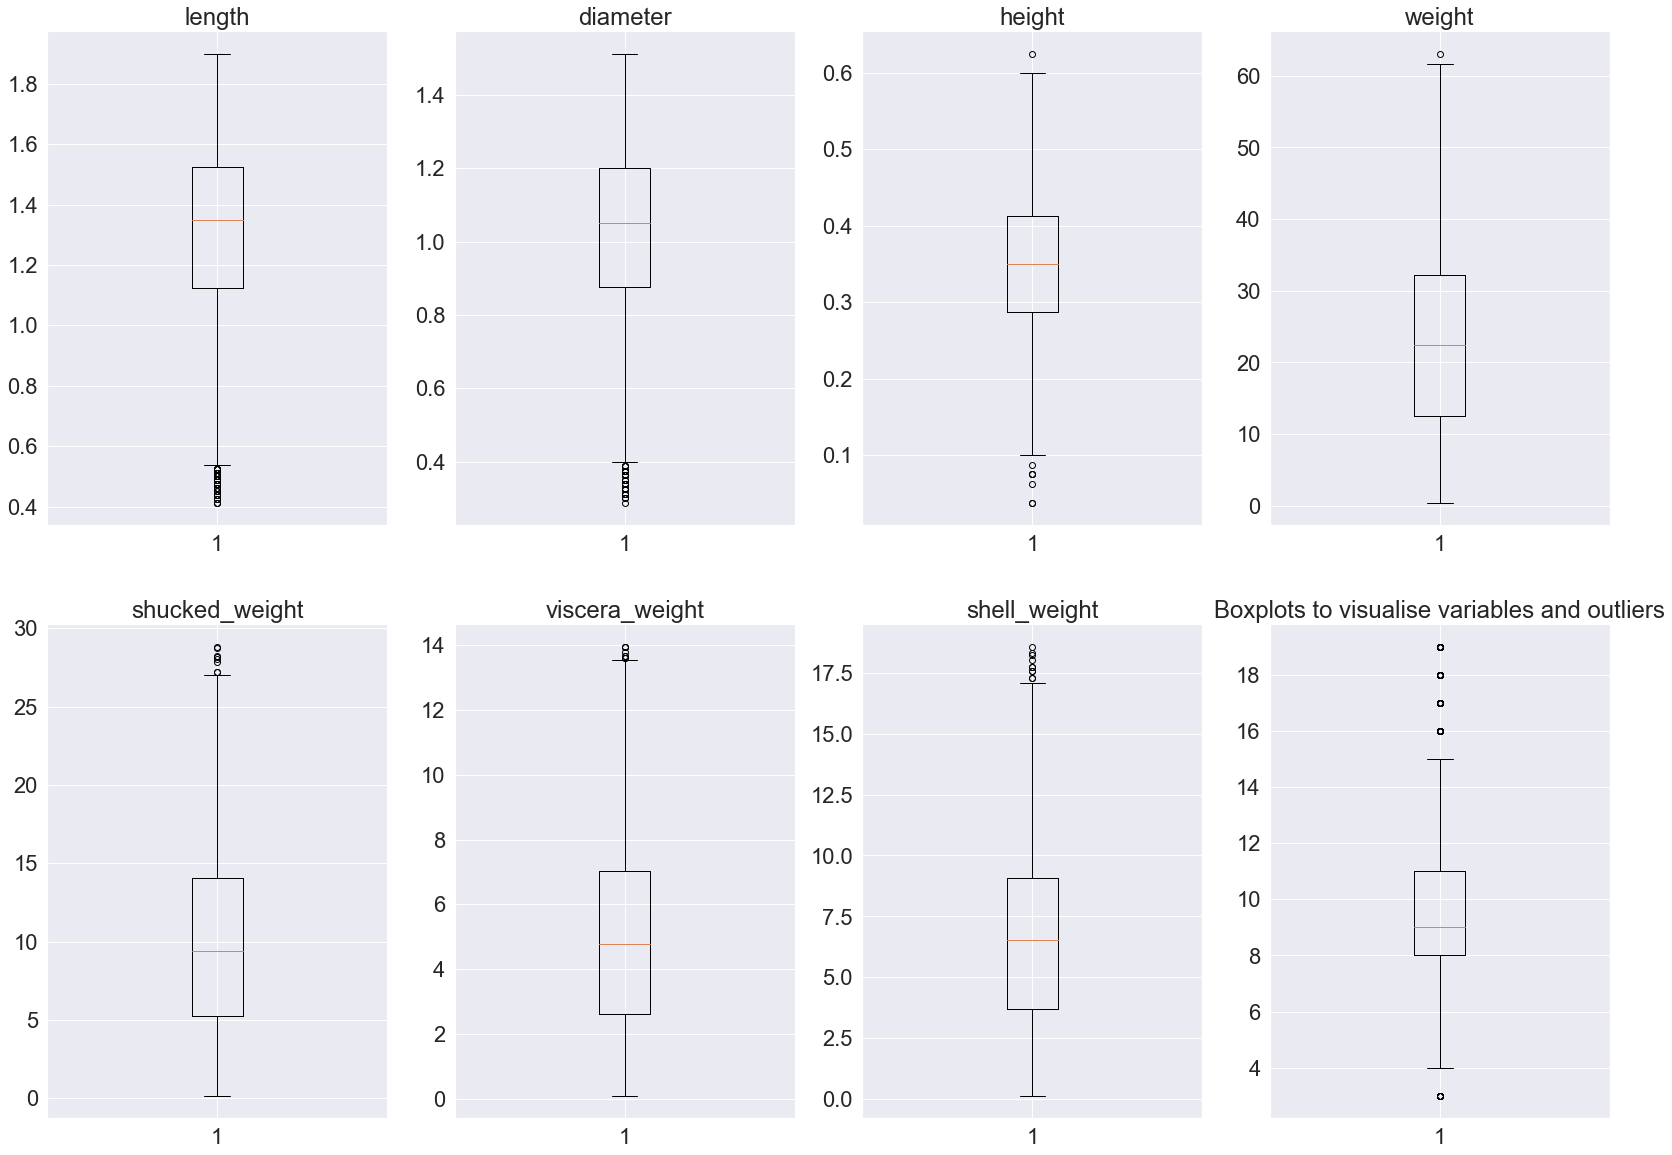

In [23]:
# Outliers detection for variables
columns = ["length","diameter","height","weight","shucked_weight","viscera_weight","shell_weight","age","sex"]

fig, axs = plt.subplots(2, 4,figsize=(28, 20))
axs[0, 0].boxplot(crab_df_woo["length"])
axs[0, 0].set_title('length')
axs[0, 1].boxplot(crab_df_woo["diameter"])
axs[0, 1].set_title('diameter')
axs[0, 2].boxplot(crab_df_woo["height"])
axs[0, 2].set_title('height')
axs[0, 3].boxplot(crab_df_woo["weight"])
axs[0, 3].set_title('weight')
axs[1, 0].boxplot(crab_df_woo["shucked_weight"])
axs[1, 0].set_title('shucked_weight')
axs[1, 1].boxplot(crab_df_woo["viscera_weight"])
axs[1, 1].set_title('viscera_weight')
axs[1, 2].boxplot(crab_df_woo["shell_weight"])
axs[1, 2].set_title('shell_weight')
axs[1, 3].boxplot(crab_df_woo["age"])
axs[1, 3].set_title('age')
plt.title("Boxplots to visualise variables and outliers")
plt.show()

# So we can see that we have far fewer outliers now. We can compare it with the boxplot presented above

## Try linear regression model on this outlier free crab data set

In [24]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
crab_df_woo_enc = ohe.fit_transform(crab_df_woo)
crab_df_woo_enc.head()

,sex_F,sex_M,sex_I,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,1,0,0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,0,1,0,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,0,0,1,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,1,0,0,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,0,0,1,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [25]:
X = crab_df_woo_enc.drop("age",axis=1)
y = crab_df_woo_enc[["age"]]

In [26]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [27]:
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
r2_lin_reg_non_standard = reg.score(X_test,y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_non_standard = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_lin_reg_non_standard = mean_absolute_error(y_test, y_pred_test)
logger.debug(r2_lin_reg_non_standard)
logger.debug(mse_lin_reg_non_standard)
logger.debug(mae_lin_reg_non_standard)
# The r square value is not reassuring. There are a number of techniques that can be used here. 
# For example we know that the data is not standardised. One technique could be to standardise the data
# Note: Since intercept is set to False, data will be centered before model is fit

2019-12-04 23:14:52,945 - crab_analysis - DEBUG - 0.5018091833949205
2019-12-04 23:14:52,946 - crab_analysis - DEBUG - 1.9716867950146577
2019-12-04 23:14:52,947 - crab_analysis - DEBUG - 1.4777102931255683


In [28]:
# Trying k-fold cross validation to try to improve model prediction
model = linear_model.LinearRegression()
scores1 = []
models = []
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    scores1.append(model.score(X.iloc[test,:], y.iloc[test,:]))
logger.debug(sorted(scores1))

2019-12-04 23:14:53,077 - crab_analysis - DEBUG - [0.47975027548529137, 0.4861940323433742, 0.5011840203929415, 0.5096803665636402, 0.5159676806015937, 0.520834978816717, 0.527414974952724, 0.5379084403620531, 0.5464654746140564, 0.5543765266453866]


In [29]:
# 10-fold cross validation did not yield any decent results either. I noticed that that there is some improvement in model prediction 
# but its negligble 

# Now trying Linear Regression with standardisation

In [30]:
x = crab_df_woo[continuous_var_columns].values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
standardized_data = pd.DataFrame(x_scaled)
standardized_data.columns = continuous_var_columns
standardized_data["sex"] = pd.Series(raw_df["sex"].values)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


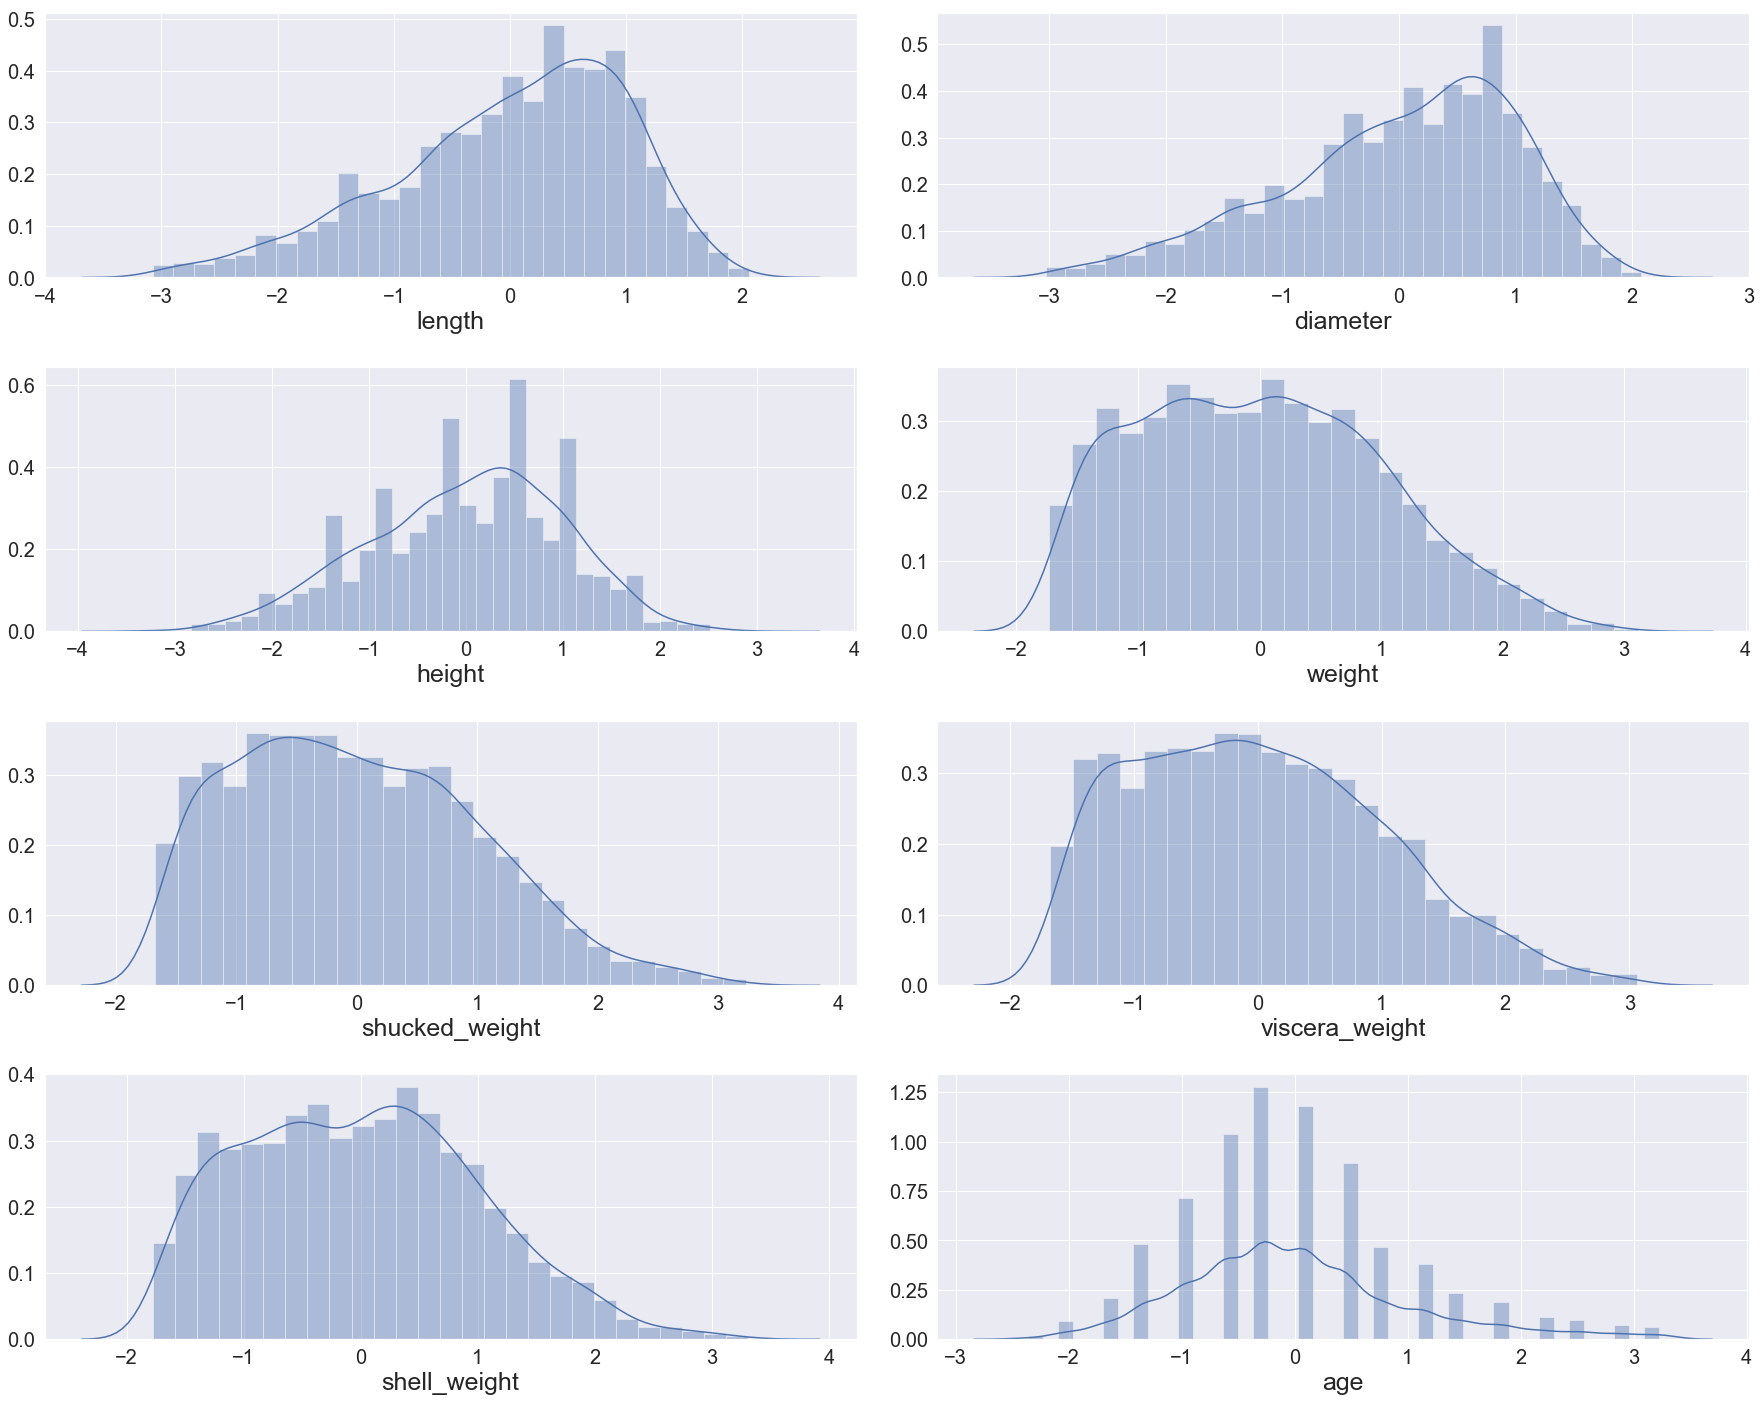

In [31]:
# Visualise the data distribution after standardization. Standard Scalar also does mean centring so don't need to do it explcitly
fig, axes = plt.subplots(4, 2, figsize=(25, 20), tight_layout=True)

sns.distplot(standardized_data["length"], color="b",  ax=axes[0, 0])
axes[0,0].set_xlabel("length", fontsize=25)
axes[0,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["diameter"], color="b",  ax=axes[0, 1])
axes[0,1].set_xlabel("diameter", fontsize=25)
axes[0,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["height"], color="b",  ax=axes[1, 0])
axes[1,0].set_xlabel("height", fontsize=25)
axes[1,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["weight"], color="b",  ax=axes[1, 1])
axes[1,1].set_xlabel("weight", fontsize=25)
axes[1,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["shucked_weight"], color="b",  ax=axes[2, 0])
axes[2,0].set_xlabel("shucked_weight", fontsize=25)
axes[2,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["viscera_weight"], color="b",  ax=axes[2, 1])
axes[2,1].set_xlabel("viscera_weight", fontsize=25)
axes[2,1].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["shell_weight"], color="b",  ax=axes[3, 0])
axes[3,0].set_xlabel("shell_weight", fontsize=25)
axes[3,0].tick_params(axis='both', which='major', labelsize=20)

sns.distplot(standardized_data["age"], color="b",  ax=axes[3, 1])
axes[3,1].set_xlabel("age", fontsize=25)
axes[3,1].tick_params(axis='both', which='major', labelsize=20)
plt.savefig("dist_plot_standard.jpg")
plt.show()

In [32]:
crab_df_enc_stand = pd.get_dummies(standardized_data,columns=["sex"], prefix="sex", drop_first=True)

In [33]:
X = crab_df_enc_stand.drop("age",axis=1)
Y = crab_df_enc_stand[["age"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [34]:
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
r2_lin_reg_standard = reg.score(X_test,y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_standard = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_lin_reg_standard = mean_absolute_error(y_test, y_pred_test)
logger.debug(r2_lin_reg_standard)
logger.debug(mse_lin_reg_standard)
logger.debug(mae_lin_reg_standard)

2019-12-04 23:14:55,794 - crab_analysis - DEBUG - 0.4953999813165204
2019-12-04 23:14:55,799 - crab_analysis - DEBUG - 0.6924952712182002
2019-12-04 23:14:55,802 - crab_analysis - DEBUG - 0.5225843304363773


In [35]:
# Trying k-fold cross validation to try to improve model prediction using standard data
model = linear_model.LinearRegression()
scores2 = []
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], Y.iloc[train,:])
    scores2.append(model.score(X.iloc[test,:], Y.iloc[test,:]))
logger.debug(sorted(scores2))

2019-12-04 23:14:55,949 - crab_analysis - DEBUG - [0.4698628749070593, 0.4728951853046989, 0.49501863241853394, 0.498183759972166, 0.505894938256449, 0.5078106684486239, 0.5097826882458287, 0.5274810174616925, 0.5338294629562041, 0.5388613583876674]


In [36]:
# It seems that standardisation actually decreased the model accuracy. One reason could be that we are removing variance from 
# the data which might have played a part in the prediction.

## Incremental Model development

In [37]:
# Since there is a lot of feature correlation, I think a better idea will be using incremental model development
# I tried a number of feature selections to calculate the R-square but none of them returned any where near the 

In [38]:
crab_df_woo.columns

Index(['sex', 'length', 'diameter', 'height', 'weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'age'],
      dtype='object')

In [39]:
X = crab_df_woo[["shucked_weight","viscera_weight","viscera_weight"]]
Y = crab_df_woo[["age"]]

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [41]:
reg = linear_model.LinearRegression()
reg.fit(X_train,Y_train)
r2_lin_reg_4vars = reg.score(X_test,Y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_4vars = np.sqrt(mean_squared_error(Y_test, y_pred_test))
mae_lin_reg_4vars = mean_absolute_error(Y_test, y_pred_test)
logger.debug(r2_lin_reg_4vars)
logger.debug(mse_lin_reg_4vars)
logger.debug(mae_lin_reg_4vars)

2019-12-04 23:14:56,505 - crab_analysis - DEBUG - 0.32973131159470603
2019-12-04 23:14:56,512 - crab_analysis - DEBUG - 2.2869914179260484
2019-12-04 23:14:56,518 - crab_analysis - DEBUG - 1.7422719070211559


In [42]:
# Model fit with just two weight variables and standardisation

In [43]:
crab_woo_subset = crab_df_woo[["shucked_weight","shell_weight","age"]]

In [44]:
x = crab_df_woo[["shucked_weight","shell_weight","age"]].values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
standardized_data = pd.DataFrame(x_scaled)
standardized_data.columns = ["shucked_weight","shell_weight","age"]

In [45]:
standardized_data.head()

,shucked_weight,shell_weight,age
0,0.410856,0.048746,-0.267126
1,-1.305368,-1.381389,-1.314072
2,-1.145381,-1.049254,-1.314072
3,-0.886008,-0.365446,0.081857
4,-1.106596,-1.342315,-1.314072


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(standardized_data[["shucked_weight","shell_weight"]], 
                                                    standardized_data[["age"]], test_size=0.2, random_state=100)

In [47]:
reg = linear_model.LinearRegression()
reg.fit(X_train,Y_train)
r2_lin_reg_2vars = reg.score(X_test,Y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_2vars = np.sqrt(mean_squared_error(Y_test, y_pred_test))
mae_lin_reg_2vars = mean_absolute_error(Y_test, y_pred_test)
logger.debug(r2_lin_reg_2vars)
logger.debug(mse_lin_reg_2vars)
logger.debug(mae_lin_reg_2vars)

2019-12-04 23:14:57,116 - crab_analysis - DEBUG - 0.46364300110251533
2019-12-04 23:14:57,119 - crab_analysis - DEBUG - 0.7139538782015337
2019-12-04 23:14:57,120 - crab_analysis - DEBUG - 0.536749877644881


## Analysing Crab Sex variable

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


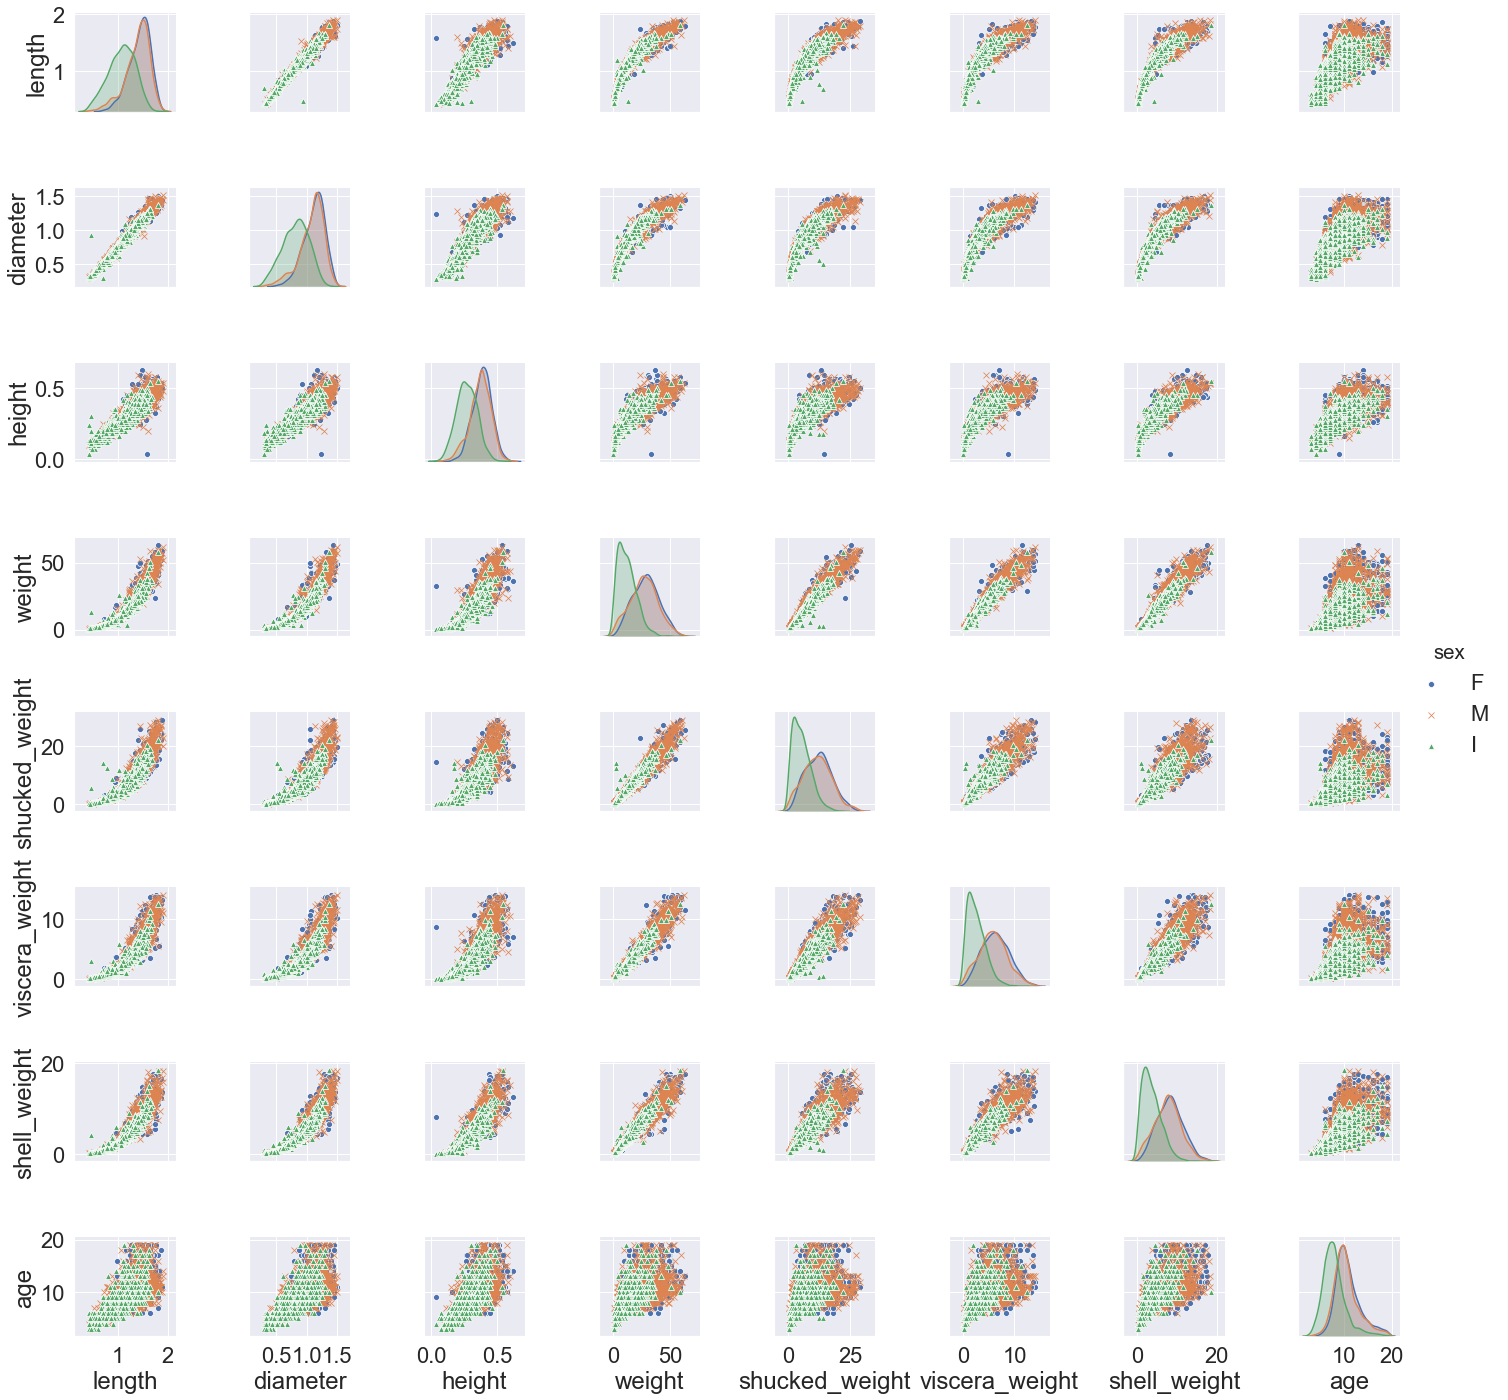

In [48]:
g = sns.pairplot(crab_df_woo, hue="sex",diag_kind="kde", markers = ["o","x","^"])
g.savefig("pair_plot_sex.jpg")

In [49]:
# By looking at this distribution, it seems that the male/female sex follows a similar trend, however, sex type 'I' 
# (which I am assuming means indeterminate) is not behaving normally (gaussian)
# I will now test regression model by removing I from my data set and modeling them separately

In [50]:
df_indeterminate = crab_df_woo[crab_df_woo.sex == "I"].copy().reset_index(drop=True)

In [51]:
df_mf = crab_df_woo[crab_df_woo.sex != "I"].copy().reset_index(drop=True)

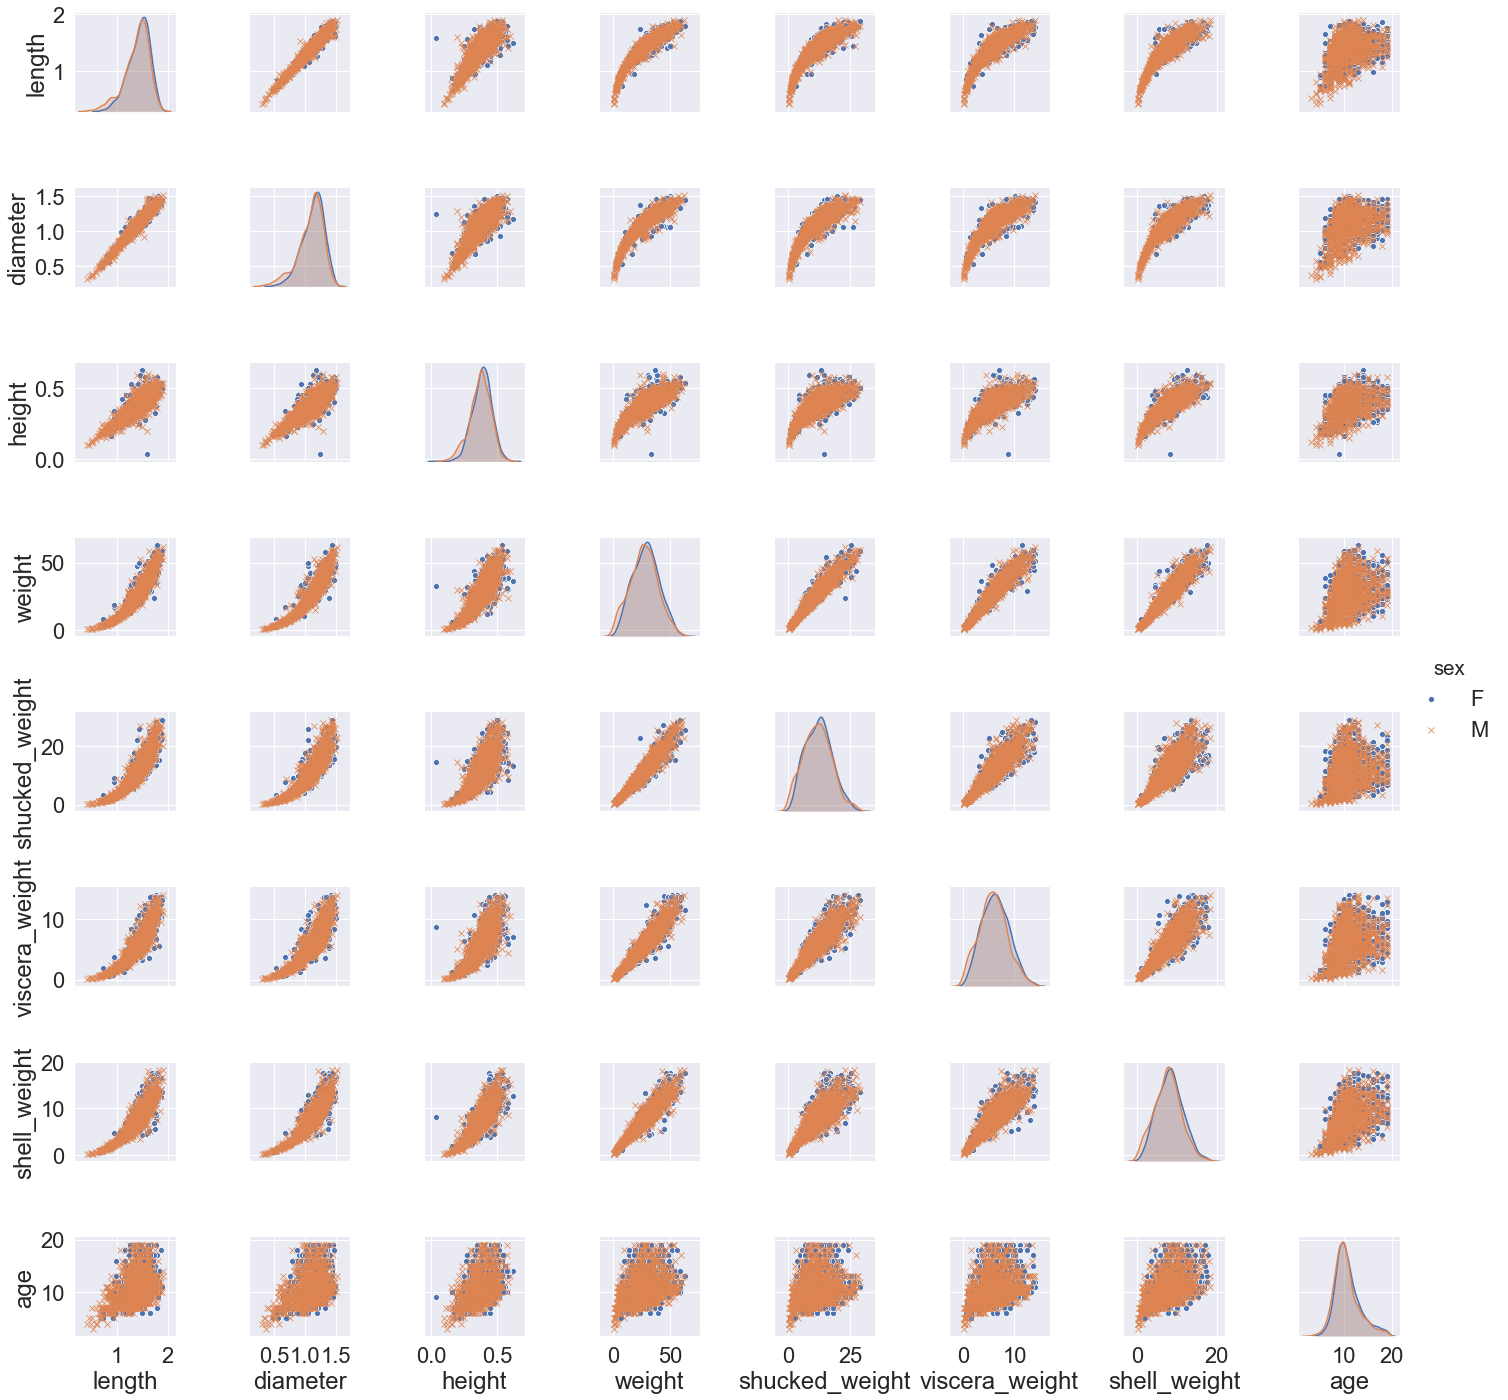

In [52]:
g = sns.pairplot(df_mf, hue="sex",diag_kind="kde", markers = ["o","x"])
# g.savefig("pair_plot_mf.jpg")

In [53]:
logger.debug("Number of male/female rows: {0}".format(len(df_mf)))
logger.debug("Number of indeterminate rows: {0}".format(len(df_indeterminate)))

2019-12-04 23:15:21,884 - crab_analysis - DEBUG - Number of male/female rows: 2542
2019-12-04 23:15:21,885 - crab_analysis - DEBUG - Number of indeterminate rows: 1214


In [54]:
correlation_matrix_i = df_indeterminate.drop(["sex"], axis=1).corr()

In [55]:
correlation_matrix_i

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
length,1.000000,0.985141,0.908041,0.925059,0.899668,0.901440,0.917188,0.684212
diameter,0.985141,1.000000,0.914195,0.928497,0.901807,0.903291,0.922403,0.694698
height,0.908041,0.914195,1.000000,0.898315,0.855408,0.879285,0.899790,0.720498
weight,0.925059,0.928497,0.898315,1.000000,0.968606,0.972679,0.970706,0.693374
shucked_weight,0.899668,0.901807,0.855408,0.968606,1.000000,0.928048,0.914392,0.615834
viscera_weight,0.901440,0.903291,0.879285,0.972679,0.928048,1.000000,0.940563,0.671952
shell_weight,0.917188,0.922403,0.899790,0.970706,0.914392,0.940563,1.000000,0.733594
age,0.684212,0.694698,0.720498,0.693374,0.615834,0.671952,0.733594,1.000000


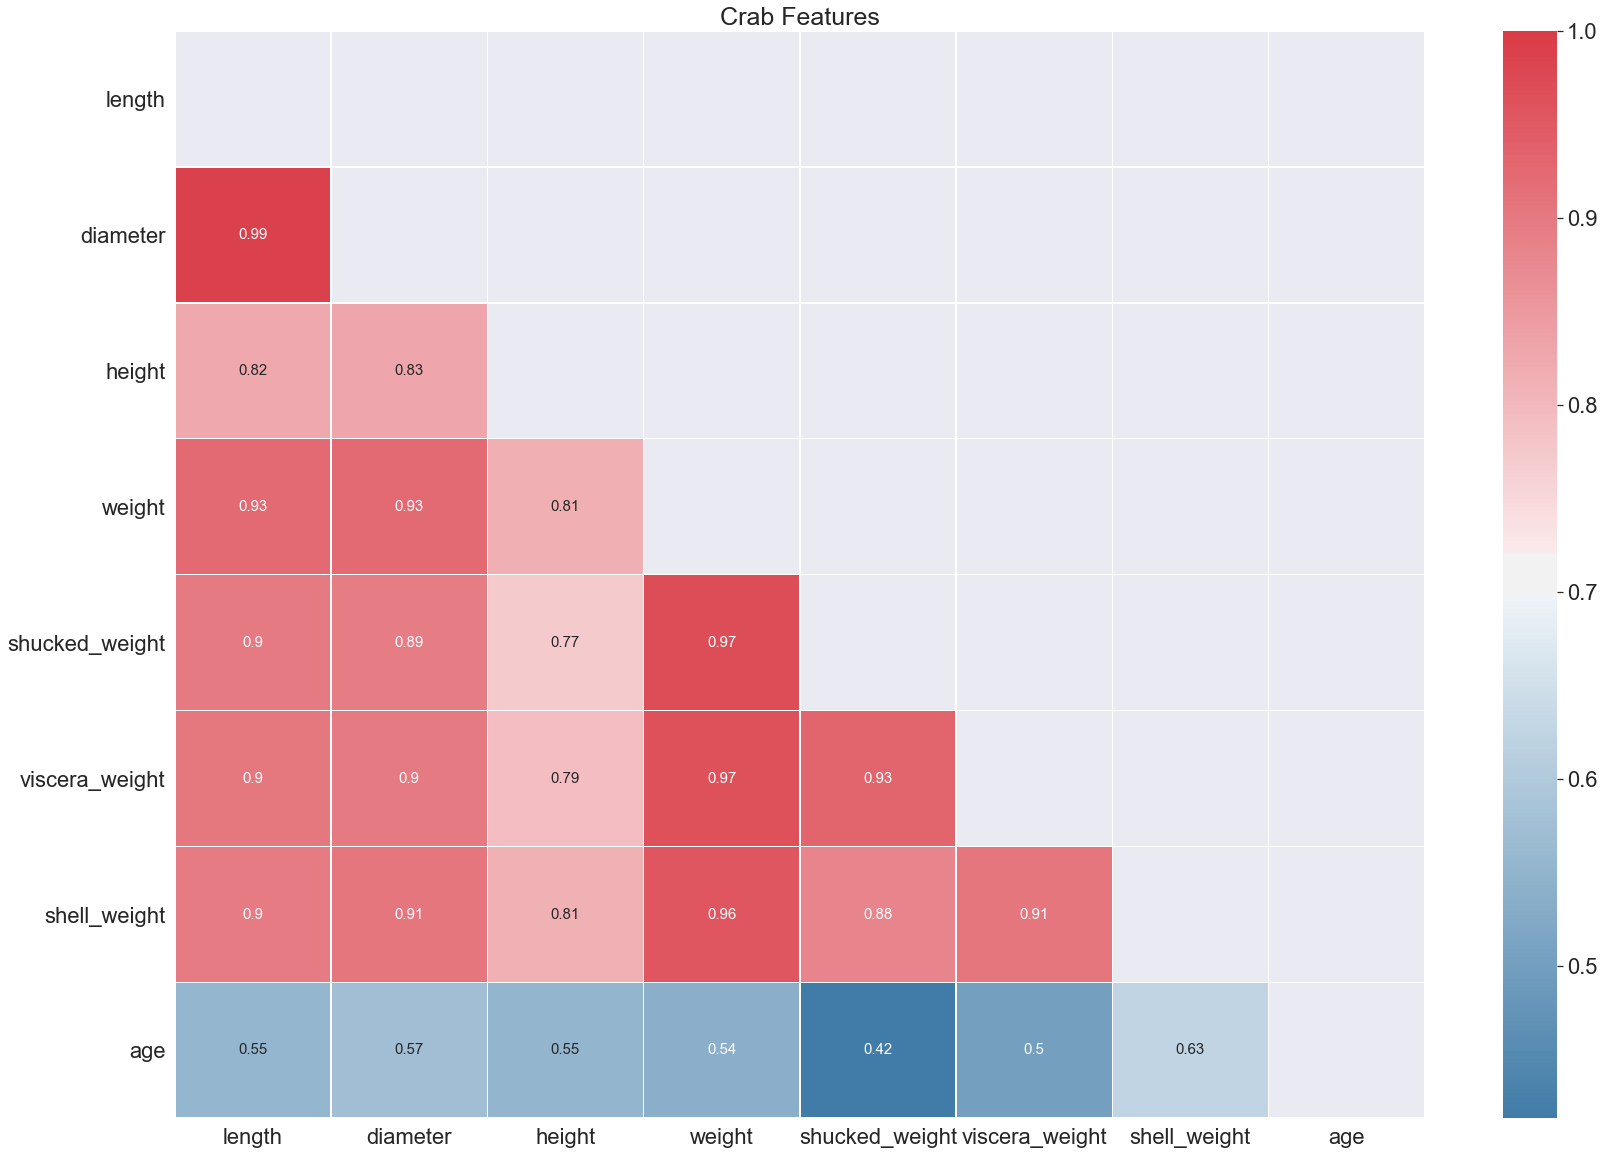

In [56]:
mask = np.zeros_like(correlation_matrix_i, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(28, 20))
cmap = sns.dark_palette("#ff5959", reverse=True, input="rgb", as_cmap=True)
cmap2 = sns.cubehelix_palette(n_colors=15,start=2, as_cmap=True, dark=0.1)
cmap3 = sns.diverging_palette(240,10, n=20, as_cmap=True)
ax.set_title("Crab Features", fontsize=25)
sns.set(font_scale=2)
sns.heatmap(correlation_matrix, mask=mask,  linewidths=.5, cmap=cmap3,annot=True, annot_kws={"size": 15})
# plt.savefig("correlation_heatmap_i.jpg")

In [57]:
X = df_indeterminate.drop(["age","sex"],axis=1)
Y = df_indeterminate[["age"]]
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
reg = linear_model.LinearRegression()
reg.fit(X_train,Y_train)
r2_lin_reg_i = reg.score(X_test,Y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_i = np.sqrt(mean_squared_error(Y_test, y_pred_test))
mae_lin_reg_i = mean_absolute_error(Y_test, y_pred_test)
logger.debug(r2_lin_reg_i)
logger.debug(mse_lin_reg_i)
logger.debug(mae_lin_reg_i)

2019-12-04 23:15:23,010 - crab_analysis - DEBUG - 0.587542504064893
2019-12-04 23:15:23,013 - crab_analysis - DEBUG - 1.6668859666120344
2019-12-04 23:15:23,017 - crab_analysis - DEBUG - 1.1290486571157876


In [58]:
# We can immediately see an increase in the R square value for Linear regression. I will now do the same for male/female cohort

In [59]:
correlation_matrix_mf = df_mf.drop(["sex"], axis=1).corr()

In [60]:
correlation_matrix_mf

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
length,1.000000,0.976619,0.822182,0.929726,0.897568,0.890610,0.885632,0.304924
diameter,0.976619,1.000000,0.831480,0.924008,0.884075,0.877409,0.895257,0.333402
height,0.822182,0.831480,1.000000,0.839891,0.771518,0.806362,0.851003,0.385317
weight,0.929726,0.924008,0.839891,1.000000,0.956583,0.945937,0.936982,0.315059
shucked_weight,0.897568,0.884075,0.771518,0.956583,1.000000,0.894425,0.838417,0.168445
viscera_weight,0.890610,0.877409,0.806362,0.945937,0.894425,1.000000,0.868828,0.282015
shell_weight,0.885632,0.895257,0.851003,0.936982,0.838417,0.868828,1.000000,0.431605
age,0.304924,0.333402,0.385317,0.315059,0.168445,0.282015,0.431605,1.000000


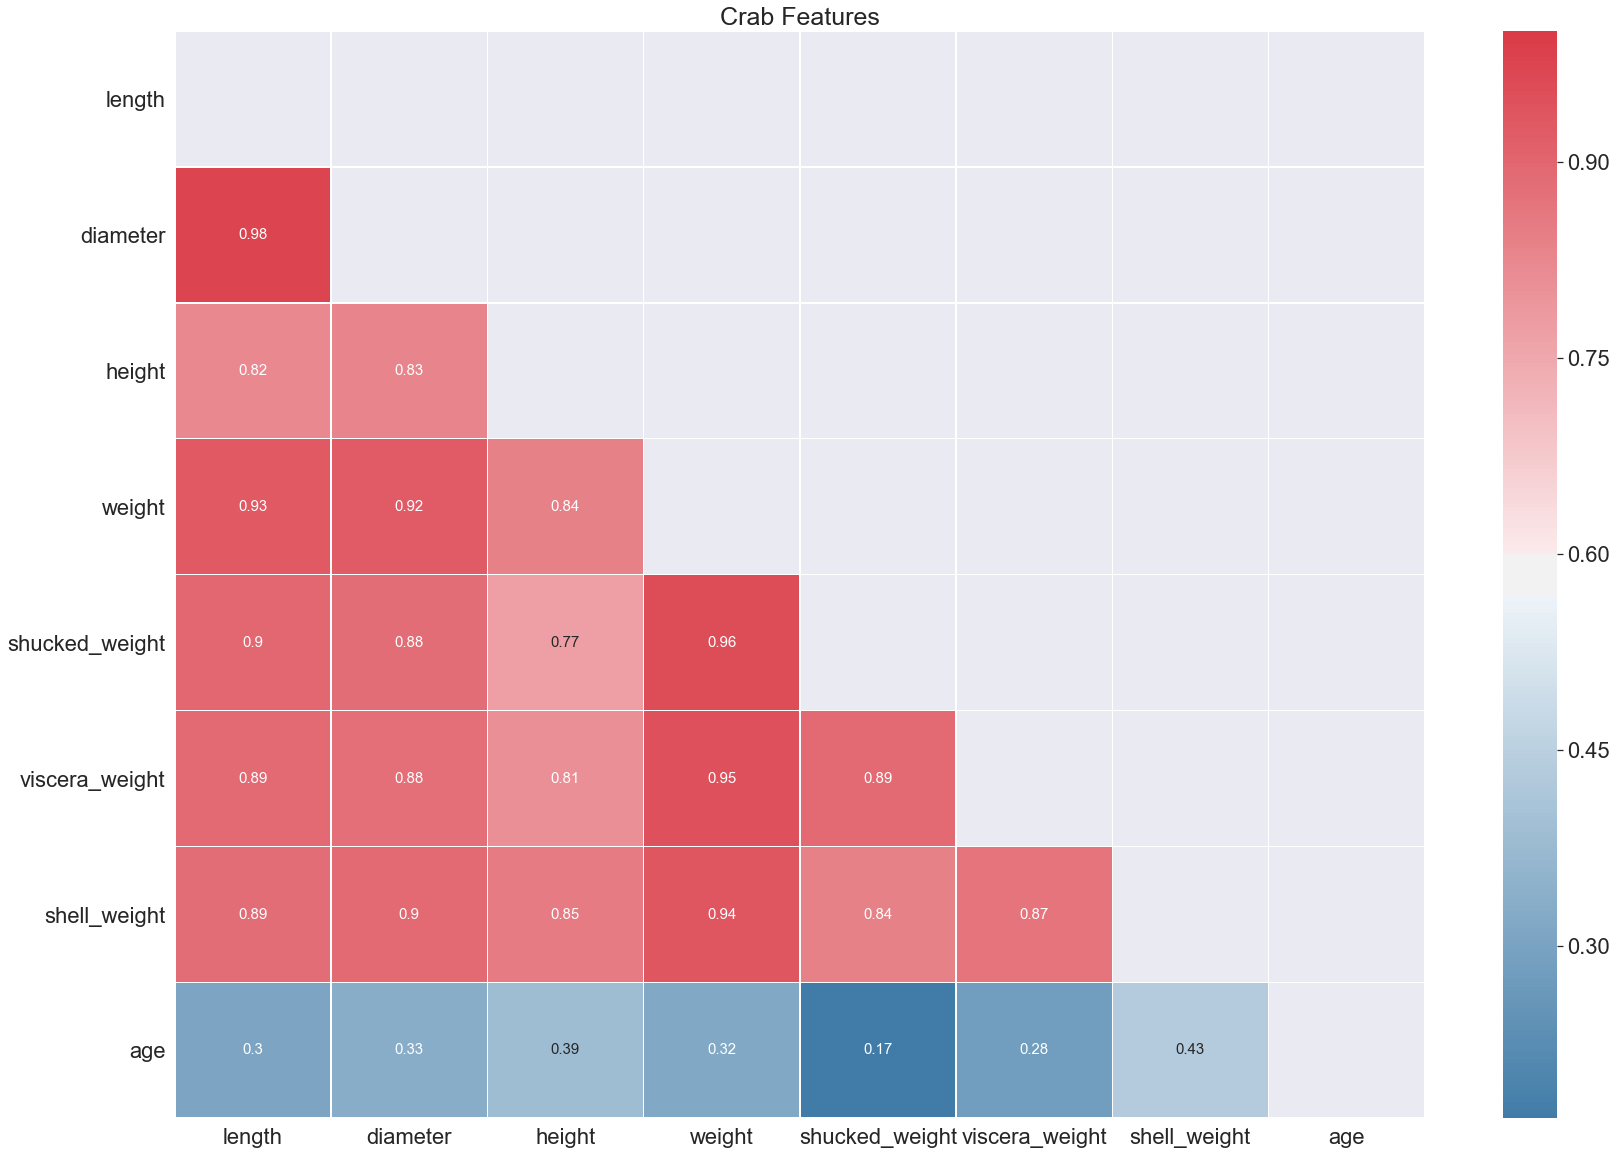

In [61]:
mask = np.zeros_like(correlation_matrix_i, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(28, 20))
cmap = sns.dark_palette("#ff5959", reverse=True, input="rgb", as_cmap=True)
cmap2 = sns.cubehelix_palette(n_colors=15,start=2, as_cmap=True, dark=0.1)
cmap3 = sns.diverging_palette(240,10, n=20, as_cmap=True)
ax.set_title("Crab Features", fontsize=25)
sns.set(font_scale=2)
sns.heatmap(correlation_matrix_mf, mask=mask,  linewidths=.5, cmap=cmap3,annot=True, annot_kws={"size": 15})
# plt.savefig("correlation_heatmap_mf.jpg")

In [62]:
# This is interesting. It seems when I only use male/female data, the features are far less correlated with age
# With such weak correlation, model building will be a challenge

In [63]:
df_mf_enc = pd.get_dummies(df_mf,columns=["sex"], prefix="sex", drop_first=True)
X = df_mf_enc.drop("age",axis=1)
Y = df_mf_enc[["age"]]
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
reg = linear_model.LinearRegression()
reg.fit(X_train,Y_train)
r2_lin_reg_mf = reg.score(X_test,Y_test)
y_pred_test = reg.predict(X_test)
mse_lin_reg_mf = np.sqrt(mean_squared_error(Y_test, y_pred_test))
mae_lin_reg_mf = mean_absolute_error(Y_test, y_pred_test)
logger.debug(r2_lin_reg_mf)
logger.debug(mse_lin_reg_mf)
logger.debug(mae_lin_reg_mf)

2019-12-04 23:15:24,006 - crab_analysis - DEBUG - 0.36237569706279427
2019-12-04 23:15:24,032 - crab_analysis - DEBUG - 1.9924613675539486
2019-12-04 23:15:24,033 - crab_analysis - DEBUG - 1.540713649294415


In [64]:
# As expected, the R-square is significantly lower, even though at this point common sense says that the age of a crab should
# be explained by its physical features (provided these data is only looking at a single specie)
# If this data is multi-specie data mixed together than predicting age might be difficult. For example specie 1 might only
# grow to a specific dimension till it reaches maturity and stops growing whereas specie 2 might be of a larger size and so
# might be younger even though they might have the same physical features as another specie of the same age

## Random Forest

In [65]:
# I will now attempt to use ensemble method, specifically Random Forest for model prediction
# Motivation for doing this is to try and figure out any non-linear trends in the data 
# since Linear regression is looking at linear trends and did not perform well
# I will use the standardised version of the outlier removed data to build a Random Forest model

In [66]:
x = crab_df_woo[continuous_var_columns].values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
standardized_data = pd.DataFrame(x_scaled)
standardized_data.columns = continuous_var_columns
standardized_data["sex"] = pd.Series(raw_df["sex"].values)
crab_forest = pd.get_dummies(standardized_data,columns=["sex"], prefix="sex")

In [67]:
X = crab_forest.drop("age",axis=1)
Y = crab_forest[["age"]]
X_train_forest, X_test_forest, Y_train_forest, Y_test_forest = train_test_split(X, Y, test_size=0.2, random_state=100)

In [68]:
forest = RandomForestRegressor(n_estimators=5000, max_depth=20, min_samples_leaf=2,min_samples_split=4,random_state=100)

In [69]:
forest.fit(X_train_forest, Y_train_forest.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

In [70]:
r2_rf = forest.score(X_test_forest, Y_test_forest)

In [71]:
y_pred_test = forest.predict(X_test_forest)
mse_rf = np.sqrt(mean_squared_error(Y_test_forest, y_pred_test))
mae_rf = mean_absolute_error(Y_test_forest, y_pred_test)
logger.debug(r2_rf)
logger.debug(mse_rf)
logger.debug(mae_rf)

2019-12-04 23:16:15,234 - crab_analysis - DEBUG - 0.5237608427145897
2019-12-04 23:16:15,235 - crab_analysis - DEBUG - 0.6727531369815171
2019-12-04 23:16:15,236 - crab_analysis - DEBUG - 0.5029307293384738


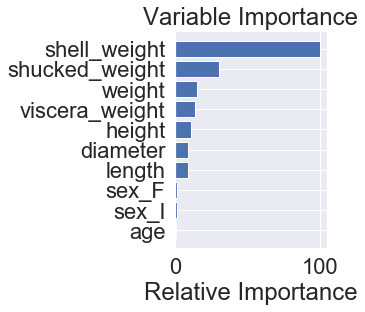

In [72]:
fm = forest.feature_importances_
feature_importance = 100.0 * (fm / fm.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, crab_forest.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
# plt.savefig("variable_importance_rf.jpg")
plt.show()

In [73]:
# Random Forest doesn't seem to perform any better either
# I will now try hyper-parameter tuning (n_estimators and max_depth) to find the best hyperparameters
# I couldn't finish hyper-parameter tuning due to time constraints

In [74]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [75]:
# gsc = GridSearchCV(estimator=RandomForestRegressor(),
#                    param_grid={'max_depth': range(10,20),'n_estimators': (2000,2500,3000,3500,4000,5000)}
#                    , cv=3, scoring='neg_mean_squared_error', verbose=0,n_jobs=1)
# grid_result = gsc.fit(X, Y.values.ravel())
# best_params = grid_result.best_params_

In [76]:
# rfr = RandomForestRegressor(max_depth=best_params["max_depth"],
#                             n_estimators=best_params["n_estimators"], random_state=False, verbose=False)                              random_state=False, verbose=False)
# # Perform K-Fold CV
# scores = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_absolute_error')

In [77]:
# predictions = cross_val_predict(rfr, X, y, cv=10)

In [78]:
# forest.predict

## XGBoost

In [79]:
# XGBoost combines boosting (where different ensemble predictors have weighted vote as opposed to bagging where the individual
# predictor's vote is average or aggregated) and gradient descent to create ensembles of decision trees. 

In [80]:
x = crab_df_woo[continuous_var_columns].values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
standardized_data = pd.DataFrame(x_scaled)
standardized_data.columns = continuous_var_columns
standardized_data["sex"] = pd.Series(raw_df["sex"].values)
crab_xgboost = pd.get_dummies(standardized_data,columns=["sex"], prefix="sex")

In [81]:
X, Y = shuffle(crab_forest.drop("age",axis=1), crab_forest[["age"]], random_state=100)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train_xgb, Y_train_xgb = X[:offset], Y[:offset]
X_test_xgb, Y_test_xgb = X[offset:], Y[offset:]

In [82]:
params = {'n_estimators': 5000, 'max_depth': 200, 'min_samples_split': 4,
          'learning_rate': 0.01, 'loss': 'ls'}

In [83]:
xgb = GradientBoostingRegressor(**params)

In [84]:
xgb.fit(X_train_xgb, Y_train_xgb.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=200,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [85]:
r2_xgb = xgb.score(X_test_xgb,Y_test_xgb)

In [86]:
y_pred_test = xgb.predict(X_test_xgb)
mse_xgb = np.sqrt(mean_squared_error(Y_test_xgb, y_pred_test))
mae_xgb = mean_absolute_error(Y_test_xgb, y_pred_test)
logger.debug(r2_xgb)
logger.debug(mse_xgb)
logger.debug(mae_xgb)

2019-12-04 23:16:53,527 - crab_analysis - DEBUG - 0.2720700964481123
2019-12-04 23:16:53,528 - crab_analysis - DEBUG - 0.7961140020180529
2019-12-04 23:16:53,529 - crab_analysis - DEBUG - 0.6070613352431489


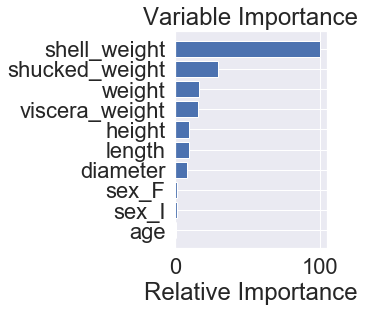

In [87]:
fm = xgb.feature_importances_
feature_importance = 100.0 * (fm / fm.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, crab_xgboost.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## PCA

In [88]:
# Since the data features high correlations with each other, it might be worth while to try dimensionality reduction technique
# to project maximum variance on a subset of features to explain the age variable.
# I will only be able to do it once I finish working on the main code to include predicted values

In [89]:
X = raw_df.drop("age",axis=1)
y = raw_df[["age"]]

In [90]:
X.head()

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970


Text(0.5, 1.0, 'PCA on raw numerical features')

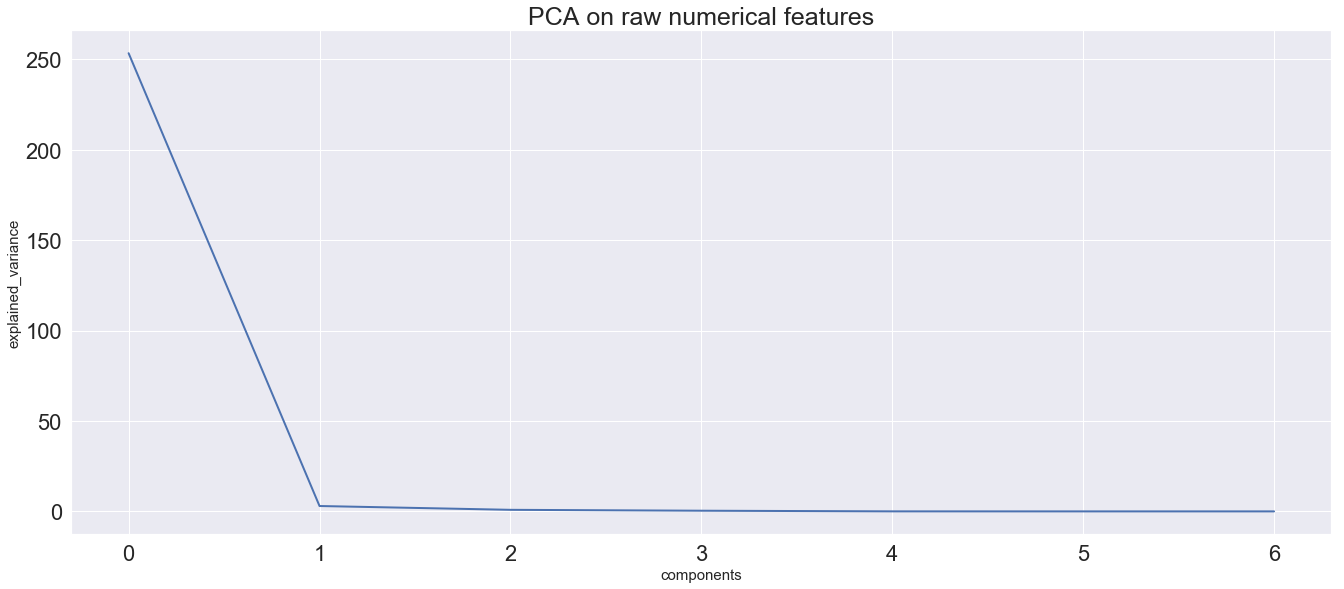

In [91]:
continuous_features = ["length","diameter","height","weight","shucked_weight","viscera_weight","shell_weight"]
pca = decomposition.PCA()
pca.fit(X[continuous_features])
plt.figure(1, figsize=(25, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('components', fontsize=15)
plt.ylabel('explained_variance', fontsize=15)
plt.title("PCA on raw numerical features", fontsize=25)
# plt.savefig("pca_raw.jpg")

In [92]:
# Since the data is highly correlated, PCA points out that most of the variance in data can be projected to just 2 features
# Of course this doesn't tell us anything since PCA requires data to be normalised and centered

In [93]:
x = crab_df_woo[continuous_features].values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
standardized_data = pd.DataFrame(x_scaled)
standardized_data.columns = continuous_features

Text(0.5, 1.0, 'PCA on standardised numerical features')

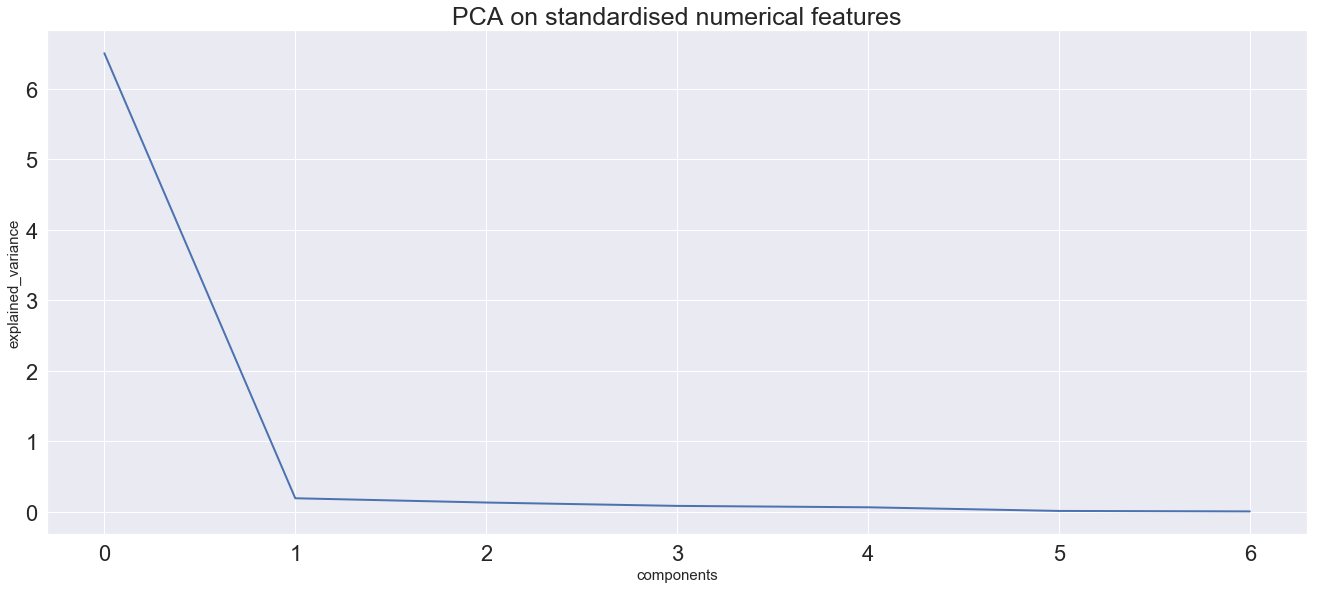

In [94]:
pca.fit(standardized_data)
plt.figure(1, figsize=(25, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('components', fontsize=15)
plt.ylabel('explained_variance', fontsize=15)
plt.title("PCA on standardised numerical features", fontsize=25)
# plt.savefig("pca_standard.jpg")

In [95]:
# Even after standardising the data, PCA shows most variance could be explained by 2 components.

In [96]:
# I will now attempt to build a GridSearch pipeline using 1-3 components and linear regression

In [97]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.2, random_state=100)

In [98]:
lr = linear_model.LinearRegression()
n_components = [1,2,3]
numerical_features = X_train_pca.dtypes == 'float'
categorical_features = ~numerical_features


In [99]:
pca = decomposition.PCA()
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(sparse=False), categorical_features)
)
pca_pipeline = Pipeline(steps=[('preprocess', preprocess),('pca',pca), ('model', lr)])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


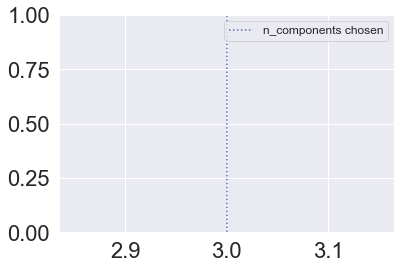

In [100]:
gs = GridSearchCV(pca_pipeline, dict(pca__n_components=n_components))
gs.fit(X_train_pca,y_train_pca)
plt.axvline(gs.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

# It seems like the grid search decided to take those 3 components. This is a bit suspect. Further investigation must be done
# in order to figure this out

In [101]:
pca = decomposition.PCA(3)
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(sparse=False), categorical_features)
)
pca_pipeline = Pipeline(steps=[('preprocess', preprocess),('pca',pca), ('model', lr)])
f_reg_ttr = TransformedTargetRegressor(regressor=pca_pipeline)

In [102]:
f_reg_ttr.fit(X_train_pca,y_train_pca)

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), sex               False
length             True
diameter           True
...('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
              transformer=None)

In [103]:
r2_pca_3features = f_reg_ttr.score(X_test_pca,y_test_pca)

In [104]:
y_pred_test = f_reg_ttr.predict(X_test_pca)
mse_pca_3features = np.sqrt(mean_squared_error(y_test_pca, y_pred_test))
mae_pca_3features = mean_absolute_error(y_test_pca, y_pred_test)
logger.debug(r2_pca_3features)
logger.debug(mse_pca_3features)
logger.debug(mae_pca_3features)

2019-12-04 23:16:56,218 - crab_analysis - DEBUG - 0.3885896021209798
2019-12-04 23:16:56,219 - crab_analysis - DEBUG - 2.3531029878097693
2019-12-04 23:16:56,219 - crab_analysis - DEBUG - 1.7400521922384038


In [109]:
df_accuracy = pd.DataFrame({"model_type":["Linear Regression","Linear Regression Standardized","Linear regression (indeterminate)"
                                          , "Linear Regression (male/female)","Linear Regression 4 basic features"
                                          ,"Linear Regression 2 important features","Random Forest","XGBoost","PCA 3 dimensions"]
                           , "r-squared":[r2_lin_reg_non_standard,r2_lin_reg_standard,r2_lin_reg_i,r2_lin_reg_mf,r2_lin_reg_4vars,r2_lin_reg_2vars, r2_rf,r2_xgb, r2_pca_3features]
                            , "rmse":[mse_lin_reg_non_standard,mse_lin_reg_standard,mse_lin_reg_i,mse_lin_reg_mf,mse_lin_reg_4vars,mse_lin_reg_2vars, mse_rf,mse_xgb, mse_pca_3features]
                            , "mae":[mae_lin_reg_non_standard,mae_lin_reg_standard,mae_lin_reg_i,mae_lin_reg_mf,mae_lin_reg_4vars,mae_lin_reg_2vars, mae_rf,mae_xgb, mae_pca_3features]
                           })

In [110]:
df_accuracy

,model_type,r-squared,rmse,mae
0,Linear Regression,0.501809,1.971687,1.477710
1,Linear Regression Standardized,0.495400,0.692495,0.522584
2,Linear regression (indeterminate),0.587543,1.666886,1.129049
3,Linear Regression (male/female),0.362376,1.992461,1.540714
4,Linear Regression 4 basic features,0.329731,2.286991,1.742272
5,Linear Regression 2 important features,0.463643,0.713954,0.536750
6,Random Forest,0.523761,0.672753,0.502931
7,XGBoost,0.272070,0.796114,0.607061
8,PCA 3 dimensions,0.388590,2.353103,1.740052
